_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote, Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat GPT, used for autompletion and debugging.*

# Project 3: Single-cell data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##
import os
import scrublet as scr  # for single-cell RNA-seq doublet detection

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
import scanpy as sc
from IPython.display import display

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
current_path = os.getcwd()
if not current_path.endswith("notebooks"):
    os.chdir(os.path.join(current_path, "notebooks"))

variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data/project-03")

In [4]:
plt.style.use("../matplotlib_style.txt")

In [5]:
np.random.seed(42)

## Project and data description

In this project, we are going to work with the typical methods and pipelines used in single-cell data analysis and get some hands-on experience with the techniques used in the field. For that, we will be using Patch-seq multimodal data from cortical neurons in mice, from Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). From the different data modalities they used, we will focus on transcriptomics and electrophysiological data. 

In a real-world scenario, single cell data rarely comes with any "ground truth" labels. Often, the goal of researchers after measuring cells is to precisely classify them, grouping them into families or assigning them cell types based on the recorded features. This is normally done using usupervised methods, such as clustering methods.

However, the single-cell data that we are using in this project has some cell types assigned to each cell. These are not "ground truth" type annotations, but were one of the results from the original Scala et al. work. Still, we are going to use those annotations for validation (despite them not really being ground truth) to sanity-check some of our analyses, such as visualizations, clustering, etc. We will mainly work with cell types (`rna_types`, 77 unique types) and cell families (`rna_families`, 9 unique families).

From the transcriptomics mRNA counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out.

## Import data

### Meta data

In [6]:
# META DATA
meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


In [7]:
meta.columns

Index(['Number', 'Cell', 'Slice', 'Date', 'Sample', 'Mouse',
       'Mouse date of birth', 'Mouse age', 'Mouse gender', 'Mouse genotype',
       'Targeted layer', 'Inferred layer', 'Cre', 'Exon reads', 'Intron reads',
       'Intergenic reads', 'Sequencing batch', 'Number of genes detected',
       'RNA family', 'RNA type', 'RNA type confidence', 'RNA type top-3',
       'ALM/VISp top-3', 'Length (bp)', 'Yield (pg/µl)', 'User',
       'Hold Time (min)', 'Soma depth (µm)', 'Soma depth (4x)',
       'Cortical thickness (4x)', 'Cortical thickness (µm)', 'Traced',
       'Exclusion reasons'],
      dtype='object')

### "Ground truth labels"

In [8]:
# filter out low quality cells in term of RNA
print(
    "There are",
    np.sum(meta["RNA family"] == "low quality"),
    "cells with low quality RNA recordings.",
)
exclude_low_quality = meta["RNA family"] != "low quality"

There are 97 cells with low quality RNA recordings.


In [9]:
rna_family = meta["RNA family"][exclude_low_quality]
rna_type = meta["RNA type"][exclude_low_quality]
rna_family

0          ET
1          IT
2          IT
3          ET
4          ET
        ...  
1323       IT
1324       IT
1325     Sncg
1326       ET
1328    Pvalb
Name: RNA family, Length: 1232, dtype: object

In [10]:
print(len(np.unique(rna_family)))
print(len(np.unique(rna_type)))

9
77


In [11]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [12]:
rna_type_colors = np.vectorize(dict_rna_type_colors.get)(rna_type)

### Transcriptomic data

In [13]:
# READ COUNTS
data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

# filter out low quality cells in term of rna family
exonCounts = data_exons.values.transpose()[exclude_low_quality]
print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1232, 42466)


In [14]:
# GENE LENGTH
data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values

### Electrophysiological features

In [15]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [16]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData[exclude_low_quality]
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1232, 29)
(1224, 17)


In [17]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

# Research questions to investigate

**1) Inspect the data by computing key statistics.** For RNA counts, you can compute and plot statistics, e.g. total counts per cell, number of expressed genes per cell, mean count per gene, variance per gene, mean-variance relationship... See https://www.embopress.org/doi/full/10.15252/msb.20188746 for common quality control statistics. Keep in mind that the RNA data in this project is read counts, not UMI counts, so it is not supposed to follow a Poisson distribution. To get an idea of the technical noise in the data, you can plot count distributions of single genes within cell types (like in the lecture). 

Similarly, you can compute and plot statistics over the electrophyiological data. Also, investigate the distribution of "ground truth" labels. Comment about other relevant metadata, and think if you can use it as some external validation for other analyses. If you do use other metadata throughout the project, explain why and what you get out of it. Take into account that certain features may not be very informative for our purposes (e.g. mouse age), so only choose features that provide you with useful information in this context. If you want to get additional information about the metadata, have a look at the extended data section in the original publication (e.g., cre-lines in Figure 1c in the extended data).

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).
    

---
---
# Code & Solution

---
---

## Metrics for Transcriptomics Data based on Luecken & Theis (2019)

---

### 1) Cell-level Quality Control

- **Total counts per cell (count depth)**  
  Sum of all detected transcripts in each barcode; low values flag empty droplets, high values flag potential doublets.

- **Number of genes detected per cell**  
  Count of unique genes with ≥1 read; informs library complexity and cell viability.

- **Mitochondrial content (% mito reads)**  
  Fraction of reads mapping to mitochondrial genes; high percentages indicate stressed or dying cells.

- **Doublet score**  
  Algorithmic probability that a barcode captures more than one cell (e.g., Scrublet, DoubletFinder).

*Guideline:* Visualize these three QC covariates jointly and set permissive thresholds; revisit after initial downstream analysis for unforeseen cell populations.

---

### 2) Gene-level Filtering

- **Detection frequency**  
  Number (or percent) of cells in which a gene is expressed; genes with very low frequency are uninformative.

- **Average (normalized) expression**  
  Mean expression across cells; extremely low or high values may bias downstream analyses.

- **Dispersion (variance/mean)**  
  Overdispersion metric used to select highly variable genes (HVGs) for feature selection.

*Rule of thumb:*  
Filter out genes detected in fewer cells than the smallest cluster size you aim to resolve (e.g., <20 cells).

---

### 3) Normalization Diagnostics

- **Size factors**  
  Cell-specific scaling factors (e.g., via scran pooling) that correct for sequencing depth disparities.

- **Mean-variance trend**  
  Post-normalization relationship; a flat trend indicates removal of depth-related variance.

- **Log-transformation stability**  
  After log(x+1), check that data skewness is mitigated and fold-change interpretations hold.

*Tip:*  
Compare alternative normalization methods (CPM, scran, downsampling) using dedicated tools (e.g., scone) to pick the best fit for your data.

---

### 4) Batch Effect Assessment

| Metric                      | Purpose                                                         |
|-----------------------------|-----------------------------------------------------------------|
| Variance partitioning       | % variance attributed to batch vs. biological factors           |
| kBET acceptance rate        | Statistical test for local mixing of batches                    |
| Local Inverse Simpson’s Index (LISI) | Quantifies neighborhood batch diversity                |
| PCA-based silhouette score  | Separation of cells by batch in low-dimensional embedding       |

*Best practice:*  
Design experiments to minimize batch effects (multiplexing, cell hashing) and then apply ComBat or linear regression for within-experiment correction.

---

### 5) Integration & Clustering Metrics

- **Silhouette width**  
  Measures how similar each cell is to its own cluster vs. other clusters.

- **Adjusted Rand Index (ARI)**  
  Compares clustering results to known labels or gold standards.

- **Normalized Mutual Information (NMI)**  
  Evaluates similarity between two partitions; useful when labels are probabilistic.

- **Clustering stability**  
  Re-run clustering on data subsets or bootstraps to assess robustness of cluster assignments.

---

### 6) Trajectory & Pseudotime Quality

- **Moran’s I for trajectory genes**  
  Spatial autocorrelation of gene expression along inferred trajectory.

- **Kendall’s τ correlation**  
  Agreement between pseudotime ordering and known marker progression.

- **Branch assignment consistency**  
  Cross-validation of lineage splits using subsampling.

---

References  
1. Luecken MD, Theis FJ. Current best practices in single-cell RNA-seq analysis: a tutorial. Mol Syst Biol. 2019;15:e8746.

## 1.1 Cell-level Quality Control Metrics (on the non-normalized data)

In [18]:
# total counts per cell
total_counts_per_cell = np.sum(exonCounts, axis=1)
print(
    "Range of total counts per cell:",
    np.min(total_counts_per_cell),
    "to",
    np.max(total_counts_per_cell),
)

# number of expressed genes per cell
n_expressed_genes_per_cell = np.sum(exonCounts > 0, axis=1)
print(
    "Range of number of expressed genes per cell:",
    np.min(n_expressed_genes_per_cell),
    "to",
    np.max(n_expressed_genes_per_cell),
)

# mitochondrial content
mito_genes_mask = np.char.startswith(genes.astype(str), "mt-")
print(f"Found {np.sum(mito_genes_mask)} mitochondrial genes.")
mito_counts = exonCounts[:, mito_genes_mask]
percent_mito = (np.sum(mito_counts, axis=1) / np.sum(exonCounts, axis=1)) * 100
print(
    "Range of mitochondrial content:",
    f"{np.min(percent_mito):.2f}% to {np.max(percent_mito):.2f}%",
)

# mean count per gene
mean_counts_per_gene = np.mean(exonCounts, axis=0)

# variance per gene
var_counts_per_gene = np.var(exonCounts, axis=0)

# detection frequency per gene
detection_frequency_per_gene = np.sum(exonCounts > 0, axis=0)

Range of total counts per cell: 2648 to 18479190
Range of number of expressed genes per cell: 1202 to 18118
Found 28 mitochondrial genes.
Range of mitochondrial content: 0.02% to 48.97%


In [19]:
# Calculate optimal bin numbers using the Freedman-Diaconis rule
def get_fd_bins(data):
    """
    Calculates the optimal number of bins for a histogram using the Freedman-Diaconis rule.
    If the rule suggests too few bins (<=1), it falls back to using the number of unique
    data points, capped at 50, for better visualization of sparse data.
    If there is only one unique data point (e.g., all zeros), it returns a bin range
    centered around that value.
    """
    unique_values = np.unique(data)
    if len(unique_values) == 1:
        # Handle case with only one unique value, e.g., all zeros.
        # Create a small bin around the single value.
        value = unique_values[0]
        return [value - 0.5, value + 0.5]

    # Freedman-Diaconis rule
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    if iqr > 0:
        bin_width = 2 * iqr * (len(data) ** (-1 / 3))
        if bin_width > 0:
            num_bins = int((np.max(data) - np.min(data)) / bin_width)
            # If FD rule gives a reasonable number of bins, use it.
            if num_bins > 1:
                return num_bins

    # Fallback for sparse data or when FD rule is not informative
    # Use the number of unique values, but cap it at 50 to avoid too many bins.
    num_bins = len(unique_values)
    return min(num_bins, 50)

In [20]:
# Calculate Freedman-Diaconis bins for the different metrics
bins_total_counts = get_fd_bins(total_counts_per_cell)
bins_expressed_genes = get_fd_bins(n_expressed_genes_per_cell)
bins_percent_mito = get_fd_bins(percent_mito)
bins_detection_frequency = get_fd_bins(detection_frequency_per_gene)

/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_29400/3609495938.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


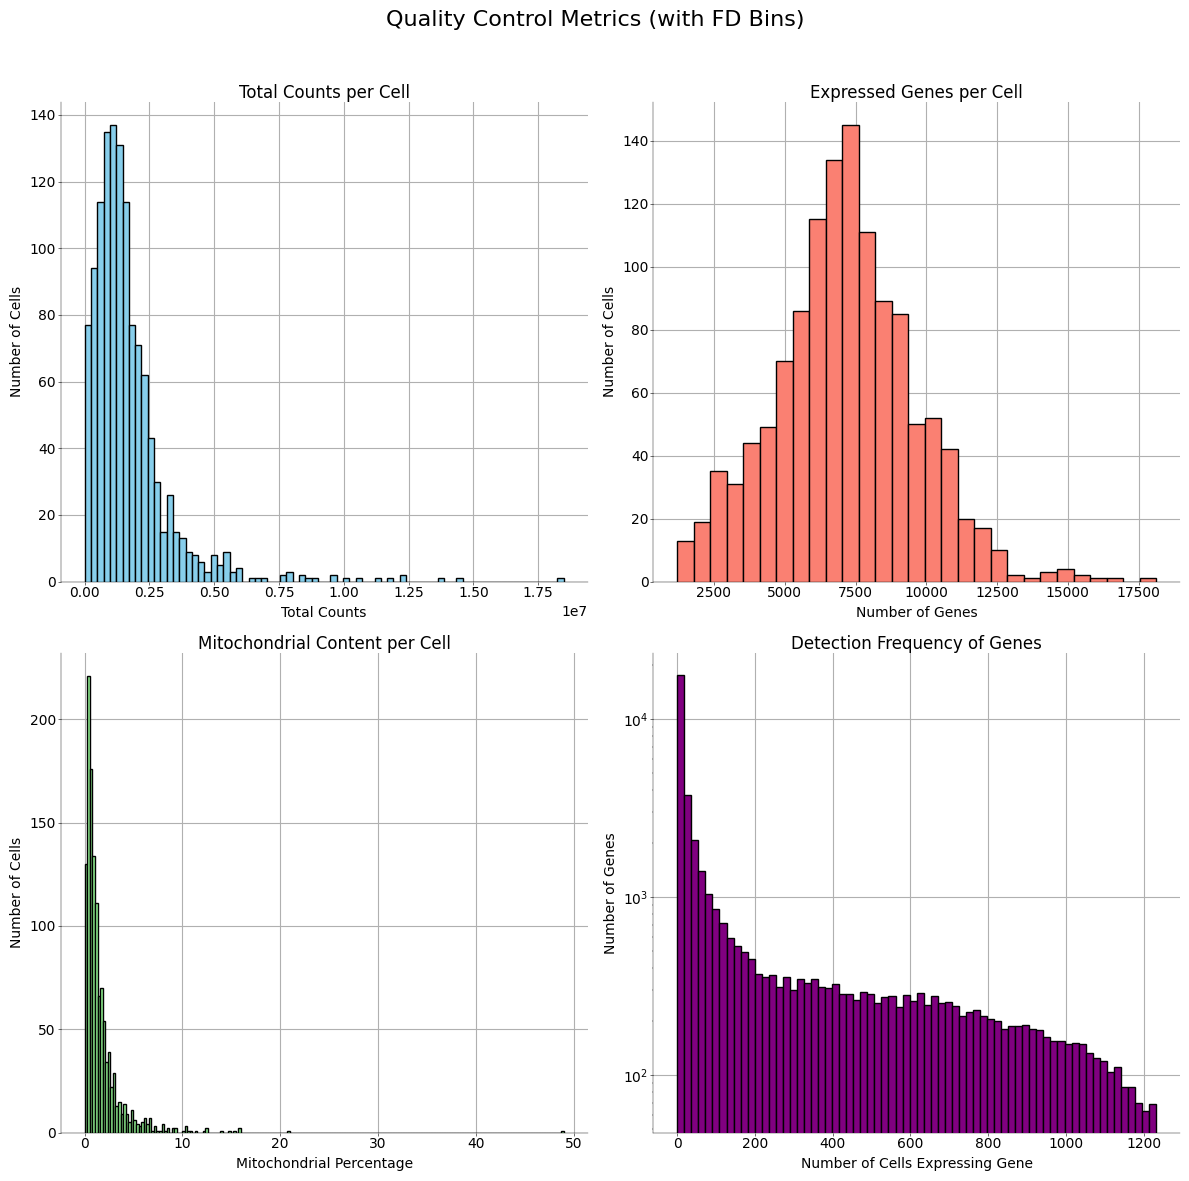

In [21]:
# plot the the counts together on one plot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Quality Control Metrics (with FD Bins)", fontsize=16)

# Plot 1: Total counts per cell
axes[0, 0].hist(
    total_counts_per_cell,
    bins=bins_total_counts,
    color="skyblue",
    edgecolor="black",
    zorder=10,
)
axes[0, 0].set_title("Total Counts per Cell")
axes[0, 0].set_xlabel("Total Counts")
axes[0, 0].set_ylabel("Number of Cells")
axes[0, 0].grid(True)

# Plot 2: Number of expressed genes per cell
axes[0, 1].hist(
    n_expressed_genes_per_cell,
    bins=bins_expressed_genes,
    color="salmon",
    edgecolor="black",
    zorder=10,
)
axes[0, 1].set_title("Expressed Genes per Cell")
axes[0, 1].set_xlabel("Number of Genes")
axes[0, 1].set_ylabel("Number of Cells")
axes[0, 1].grid(True)

# Plot 3: Mitochondrial content
axes[1, 0].hist(
    percent_mito,
    bins=bins_percent_mito,
    color="lightgreen",
    edgecolor="black",
    zorder=10,
)
axes[1, 0].set_title("Mitochondrial Content per Cell")
axes[1, 0].set_xlabel("Mitochondrial Percentage")
axes[1, 0].set_ylabel("Number of Cells")
axes[1, 0].grid(True)

# Plot 4: Detection Frequency of Genes
axes[1, 1].hist(
    detection_frequency_per_gene,
    bins=bins_detection_frequency,
    color="purple",
    edgecolor="black",
    zorder=10,
)
axes[1, 1].set_title("Detection Frequency of Genes")
axes[1, 1].set_xlabel("Number of Cells Expressing Gene")
axes[1, 1].set_ylabel("Number of Genes")
axes[1, 1].set_yscale("log")
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Figure 1: Quality Control (QC) Metrics for Single-Cell Transcriptomic Data.** The figure displays distributions of four key QC metrics for the raw exon counts. **(Top-Left)** The total counts per cell are highly right-skewed, which is typical for scRNA-seq data. The long tail may indicate the presence of doublets, while the main peak represents viable single cells. **(Top-Right)** The number of expressed genes per cell follows a roughly normal distribution, suggesting consistent library complexity across the cell population. Cells in the extreme tails could represent low-quality libraries or doublets. **(Bottom-Left)** Mitochondrial content is low for the vast majority of cells (<5%), indicating good cell viability. The tail of cells with higher percentages likely represents stressed or dying cells that should be filtered out. **(Bottom-Right)** The gene detection frequency, shown on a log scale, highlights the sparsity of the data: many genes are detected in only a few cells, while very few genes are expressed ubiquitously. Collectively, these metrics provide a basis for filtering out low-quality cells and potential doublets to improve downstream analyses.

/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_29400/908643772.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


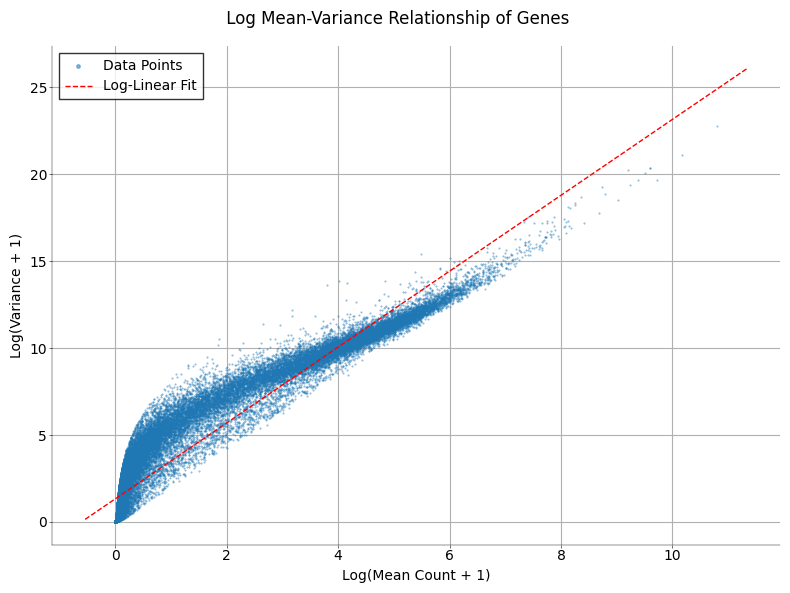

In [22]:
# Plot Mean-variance relationship
plt.figure(figsize=(8, 6))

# calculate in log + 1 space because of the large range of values and to avoid log(0)
x_data = np.log1p(mean_counts_per_gene)
y_data = np.log1p(var_counts_per_gene)

# Filter out non-finite values for robust fitting
valid_indices = np.isfinite(x_data) & np.isfinite(y_data)
x_data_fin = x_data[valid_indices]
y_data_fin = y_data[valid_indices]

plt.scatter(
    x_data_fin,
    y_data_fin,
    alpha=0.5,
    s=1,
    zorder=10,
    label="Data Points",
)

# Add a linear fit
m, b = np.polyfit(x_data_fin, y_data_fin, 1)
fit_x = np.array(plt.xlim())
plt.plot(
    fit_x,
    m * fit_x + b,
    color="red",
    zorder=20,
    linestyle="--",
    label="Log-Linear Fit",
)

plt.suptitle(" Log Mean-Variance Relationship of Genes")
plt.xlabel("Log(Mean Count + 1)")
plt.ylabel("Log(Variance + 1)")
plt.grid(True)
# legend with filling of the box
plt.legend(
    markerscale=5,
    facecolor="white",
    edgecolor="black",
    frameon="box",
    loc="upper left",
)
plt.tight_layout()
plt.show()

 **Figure 2: Log-Transformed Mean-Variance Relationship for Gene Selection.** This scatter plot shows the log(variance + 1) versus the log(mean count + 1) for every gene in the dataset. The log transformation helps visualize the relationship across many orders of magnitude. The plot demonstrates the expected positive correlation where higher mean expression is associated with higher variance.The red dashed line is an empirical linear fit to the observed data, modeling the baseline trend. It is important to note that this is not a comparison to a theoretical Poisson distribution (where variance equals the mean), as the underlying read-count data is not expected to follow such a distribution due to amplification bias. These genes exhibit greater variability than predicted by their mean expression alone, suggesting they are driven by biological differences between cells rather than just technical noise. Therefore, HVGs are typically selected for downstream analyses like PCA and clustering.


### Single Gene Expression Distribution within Cell Types

Below, we select three representative genes (low, medium, and high expression) and the three most common cell types to create a grid of histograms. Each plot shows how the counts for a single gene are distributed across the cells of a particular type.

Selected genes for plotting: ['Gm47127' '4930512B01Rik' 'Letmd1']
Their mean counts are: [ 0.48782468  7.43506494 96.22483766]
Selected cell types for plotting: ['Pvalb Il1rapl2' 'L2/3 IT_3' 'Pvalb Reln']


/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_29400/40997702.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(


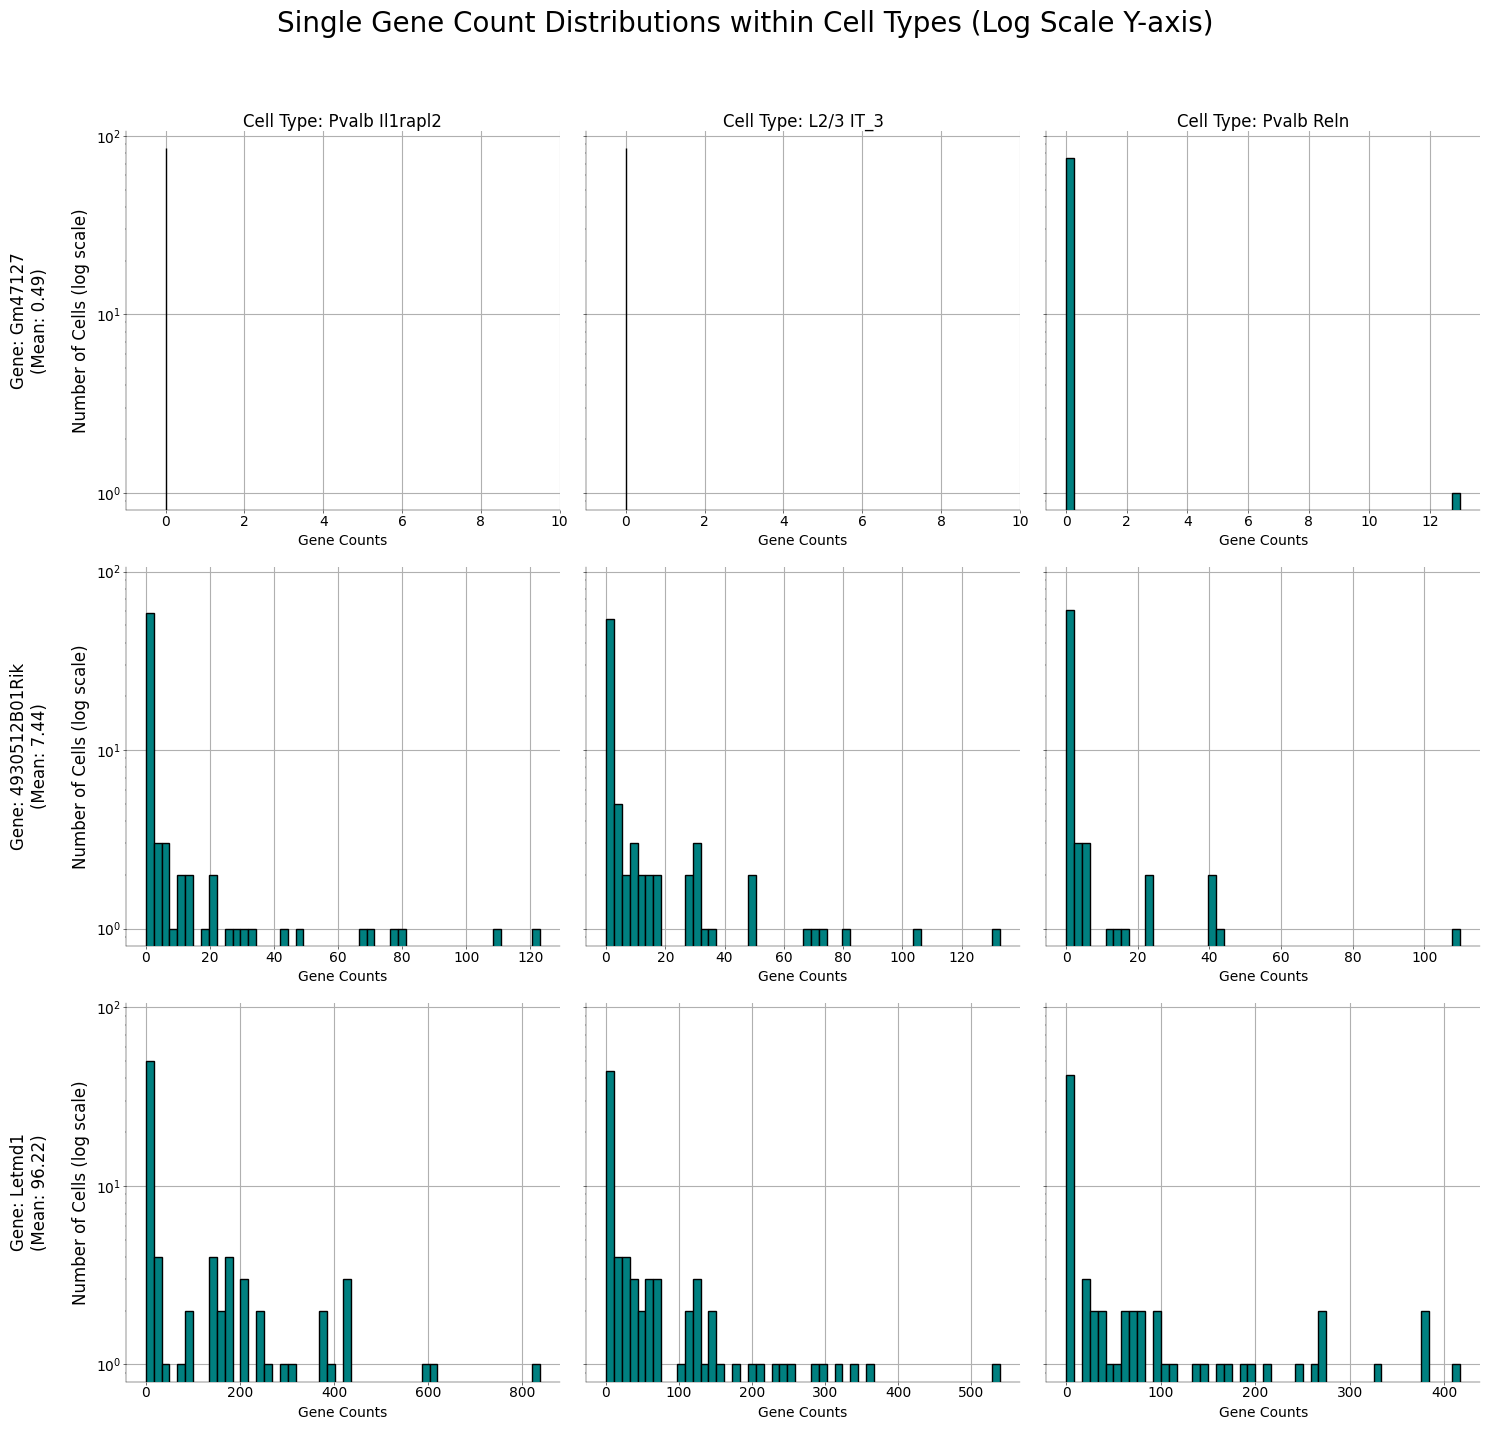

In [23]:
# 1. Select a few example genes based on their mean expression
# We sort genes by their mean count and pick representatives from different parts of the distribution.
sorted_indices = np.argsort(mean_counts_per_gene)

# Picking genes at 50th, 70th, and 90th percentiles for a better spread of expressed genes
low_expr_gene_idx = sorted_indices[int(len(sorted_indices) * 0.50)]
mid_expr_gene_idx = sorted_indices[int(len(sorted_indices) * 0.70)]
high_expr_gene_idx = sorted_indices[int(len(sorted_indices) * 0.90)]

selected_gene_indices = [
    low_expr_gene_idx,
    mid_expr_gene_idx,
    high_expr_gene_idx,
]
selected_gene_names = genes[selected_gene_indices]

print(f"Selected genes for plotting: {selected_gene_names}")
print(f"Their mean counts are: {mean_counts_per_gene[selected_gene_indices]}")

# 2. Select the three most common cell types
unique_types, counts = np.unique(rna_type, return_counts=True)
sorted_type_indices = np.argsort(counts)[::-1]  # Sort descending
selected_cell_types = unique_types[sorted_type_indices[:3]]

print(f"Selected cell types for plotting: {selected_cell_types}")


# 3. Create a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig.suptitle(
    "Single Gene Count Distributions within Cell Types (Log Scale Y-axis)",
    fontsize=20,
)

for i, gene_idx in enumerate(selected_gene_indices):
    for j, cell_type in enumerate(selected_cell_types):
        # Get the mask for the current cell type
        cell_mask = rna_type == cell_type

        # Get the counts for the current gene in the selected cells
        gene_counts_in_cell_type = exonCounts[cell_mask, gene_idx]

        ax = axes[i, j]
        ax.hist(
            gene_counts_in_cell_type,
            bins=50,  # Use a fixed number of bins for consistency
            color="teal",
            edgecolor="black",
            zorder=10,
        )
        ax.grid(True)
        ax.set_yscale("log")  # Use a log scale for the y-axis

        # If all data is zero, the plot will be a single bar.
        # Adjust x-axis to make it look like a spike, not a block.
        if len(np.unique(gene_counts_in_cell_type)) == 1:
            ax.set_xlim(-1, max(10, np.max(gene_counts_in_cell_type) + 1))

        # Set titles
        if i == 0:
            ax.set_title(f"Cell Type: {cell_type}", fontsize=12)
        if j == 0:
            ax.set_ylabel(
                f"Gene: {selected_gene_names[i]}\n(Mean: {mean_counts_per_gene[gene_idx]:.2f})\n\nNumber of Cells (log scale)",
                fontsize=12,
            )

        ax.set_xlabel("Gene Counts")

plt.tight_layout(
    rect=[0, 0.03, 1, 0.95]
)  # Adjust layout to prevent title overlap
plt.show()

**Figure 3: Single-Gene Expression Distributions Illustrate Data Sparsity and Overdispersion.** This grid of histograms visualizes the raw count distribution for three representative genes (rows, with increasing mean expression from top to bottom) across the three most abundant cell types (columns).

*   **Sparsity and "Dropouts":** The top row (gene `Gm47127`) exemplifies the extreme sparsity of scRNA-seq data. For this low-expression gene, the vast majority of cells within each type show zero counts, a phenomenon often referred to as "dropout."

*   **Overdispersion:** The distributions for the medium- and high-expression genes (`4930512B01Rik` and `Lefmd1`) are highly right-skewed, with a long tail. This indicates that the variance in counts is much larger than the mean (overdispersion), a characteristic feature of read-count data that violates the assumptions of a Poisson distribution.

*   **Stochastic Expression:** Even for a highly expressed gene like `Lefmd1` within a single cell type, there is a wide range of expression levels, highlighting the stochastic nature of gene expression at the single-cell level.

Collectively, these plots underscore why specialized statistical models, such as the Negative Binomial distribution, are required for analyzing single-cell transcriptomic data, as they can properly account for both the high frequency of zero counts and the observed overdispersion.

### Doublet detection
In scRNA-seq, a small fraction of droplets/wells may capture two or more cells - so called doublets (or multiplets). Doublets can appear as a third population of cells in-between two other populations and can therefore interfere with downstream analysis, such as clustering. It is therefore important to identify and remove them.

Running Scrublet for doublet detection...
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 1.3%
Elapsed time: 3.8 seconds
Doublet detection complete.
Number of predicted doublets: 1
   Number               Cell             Slice        Date    Sample  \
0       1  20171204_sample_2  20171204_slice_2  2017-12-04  sample 2   
1       2  20171204_sample_4  20171204_slice_4  2017-12-04  sample 4   
2       3  20171204_sample_5  20171204_slice_5  2017-12-04  sample 5   
3       4  20171204_sample_6  20171204_slice_6  2017-12-04  sample 6   
4       5  20171207_sample_1  20171207_slice_1  2017-12-07  sample 1   

         Mouse Mouse date of birth  Mouse age Mouse gender  \
0  mouse_GTOKH          2017-10-29         36            M   
1  mouse_GTOKH       

/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/scrublet/scrublet.py:507: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


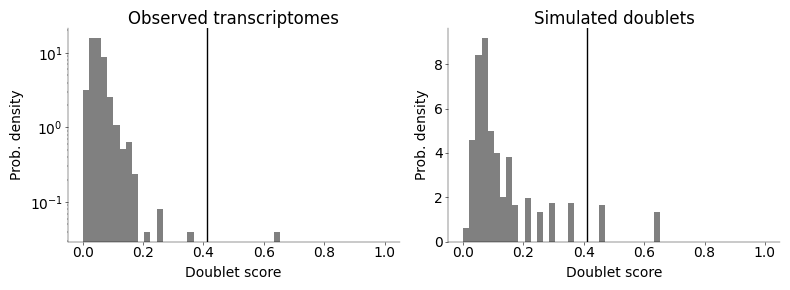

In [24]:
# Create a copy of the filtered metadata before running doublet detection
meta_filtered = meta[exclude_low_quality].copy()

# Now, let's try running Scrublet again with the sparse matrix
print("Running Scrublet for doublet detection...")
scrub = scr.Scrublet(exonCounts, expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets(
    min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30
)
print("Doublet detection complete.")

# Add doublet info to meta data
meta_filtered["doublet_scores"] = doublet_scores
meta_filtered["predicted_doublets"] = predicted_doublets

# show new columns and number of doublets
print(f"Number of predicted doublets: {np.sum(predicted_doublets)}")
print(meta_filtered.head())

# Plot a histogram of the doublet scores
scrub.plot_histogram();

## 1.2 Electrophysiological Features

Shape of final ephys data: (1224, 17)
Number of features: 17


/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_29400/3746741372.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


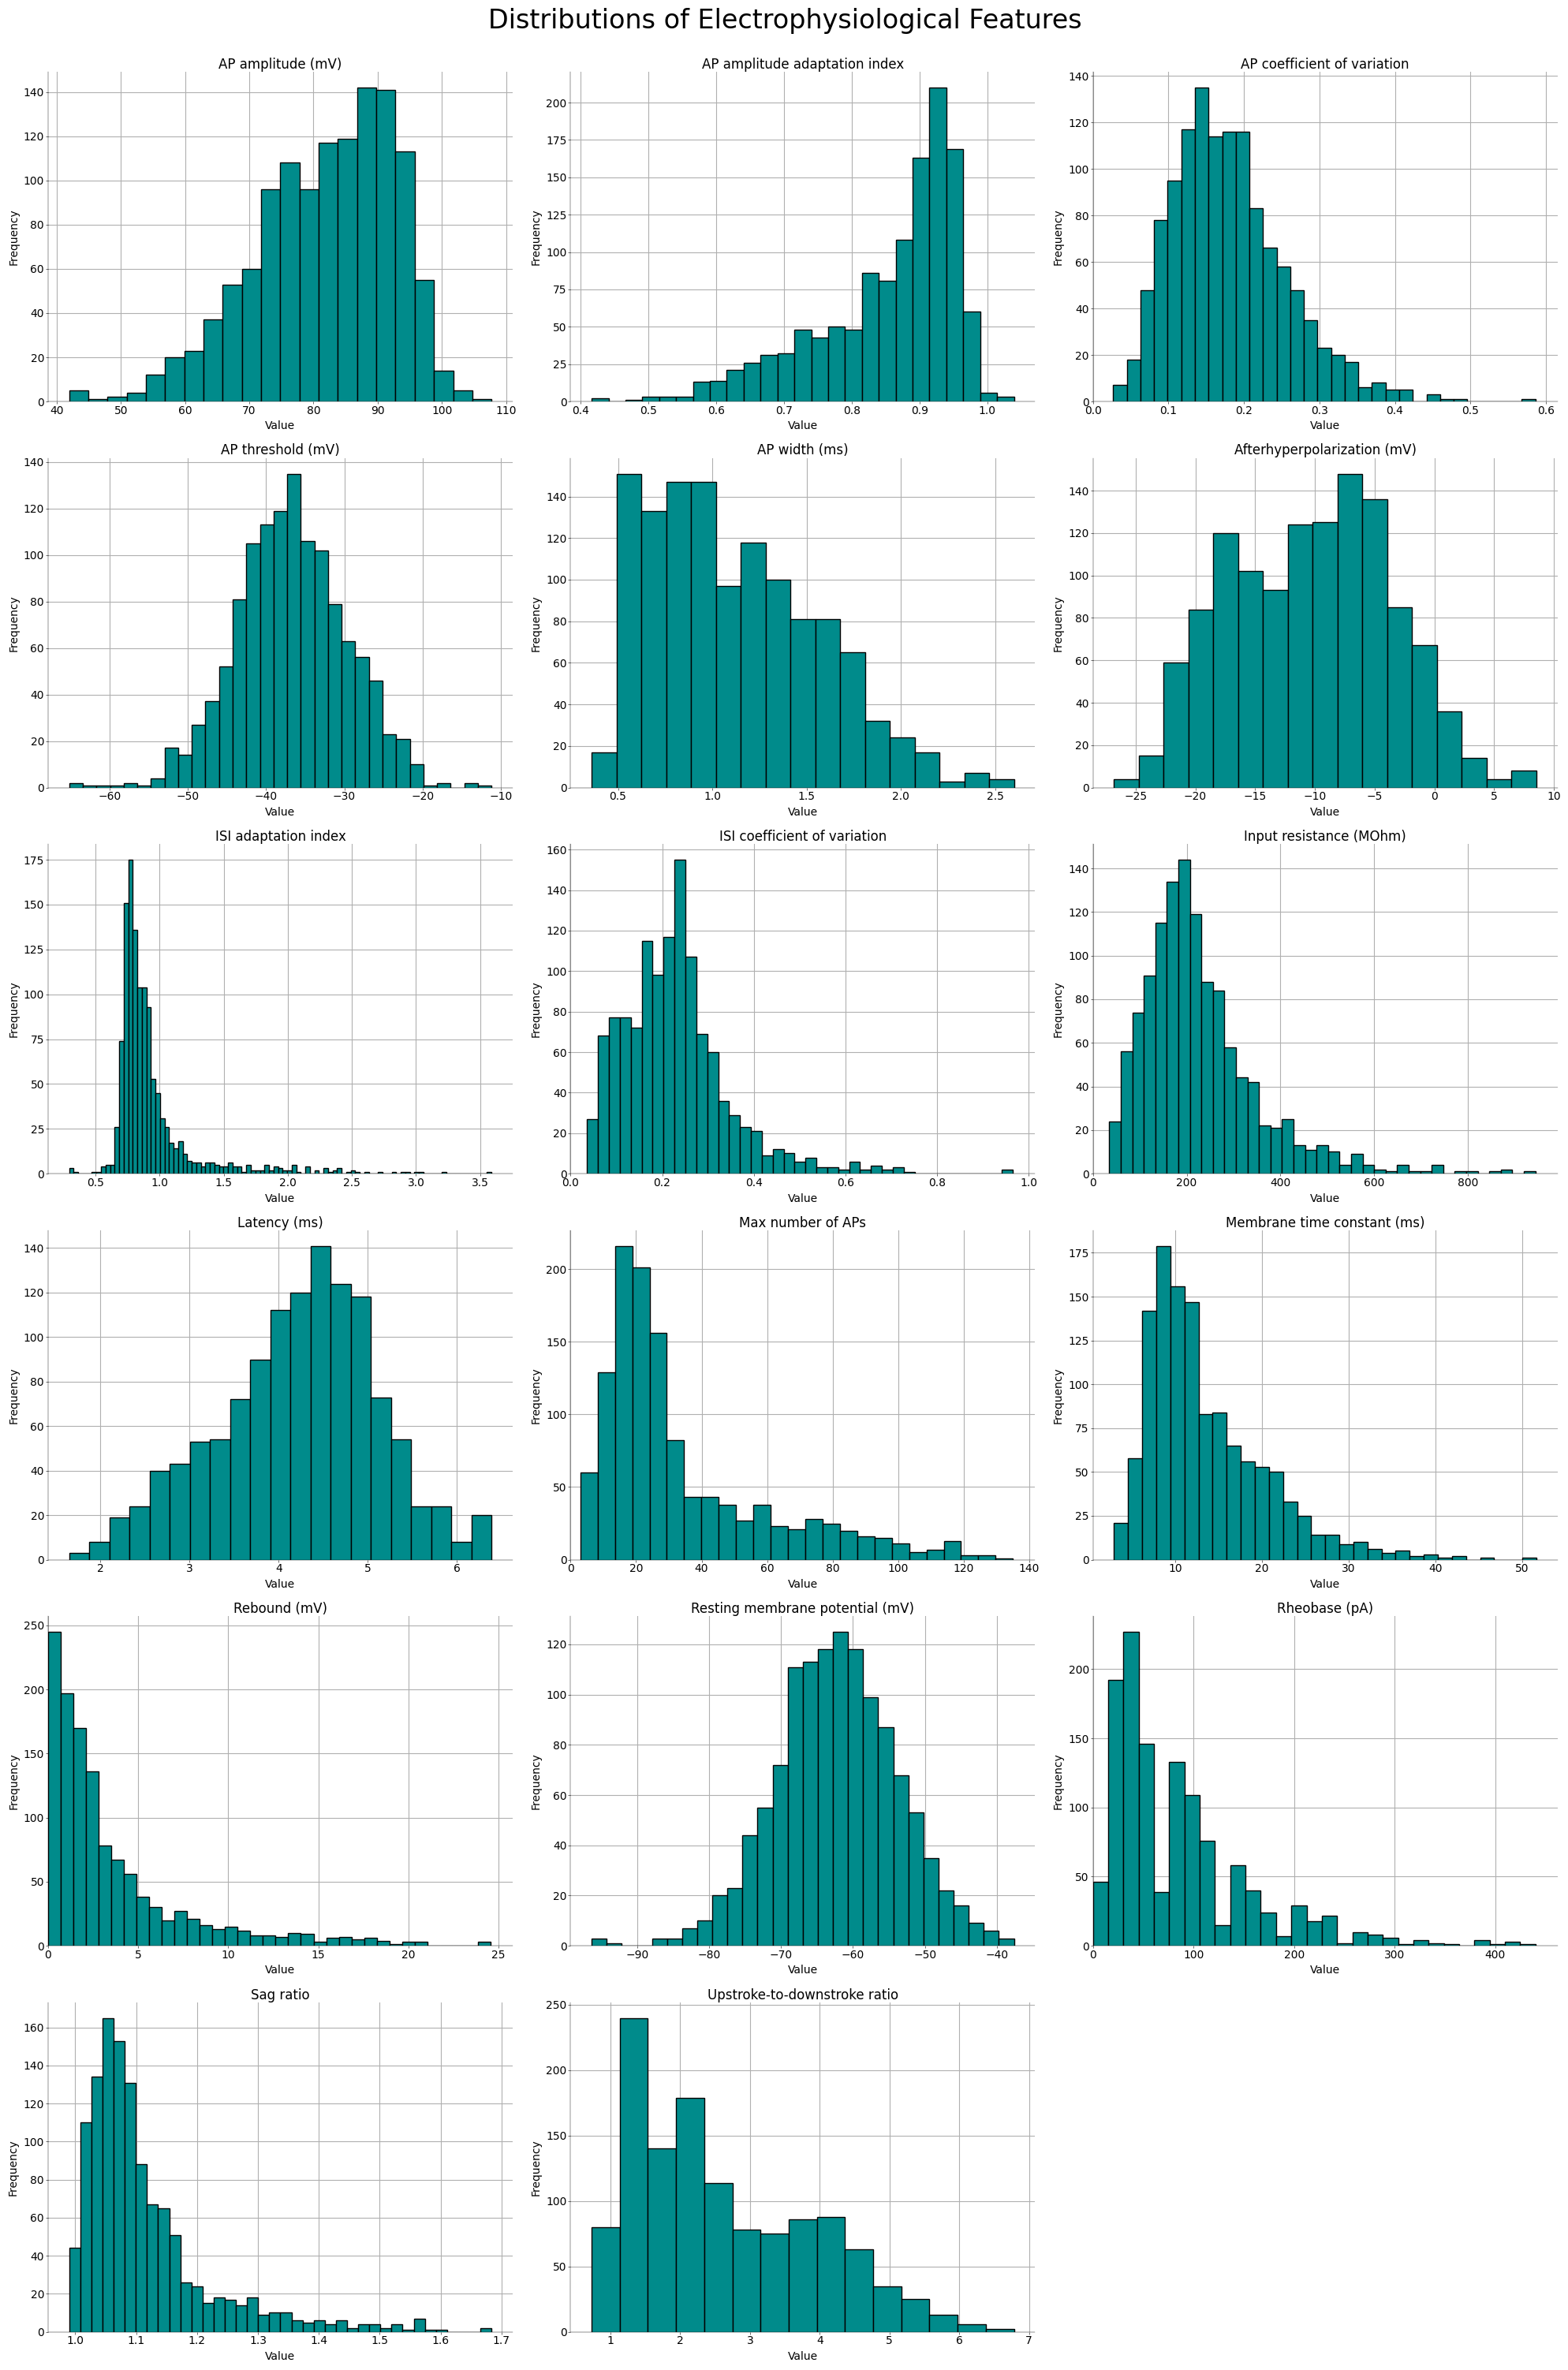

In [25]:
# Start with the data for cells that have high-quality RNA
X_ephys = ephysData[exclude_low_quality].copy()

# Apply log transformation to specified features
# The names for features to be log-transformed are defined in cell 55e28734
for feature_name in features_log:
    feature_idx = np.where(ephysNames == feature_name)[0]
    if len(feature_idx) > 0:
        # Use np.log1p for numerical stability if values are close to 0
        X_ephys[:, feature_idx] = np.log1p(X_ephys[:, feature_idx])

# Filter out excluded features
# The names for features to be excluded are defined in cell 55e28734
feature_mask = ~np.isin(ephysNames, features_exclude)
X_ephys_filtered = X_ephys[:, feature_mask]
ephysNames_filtered = ephysNames[feature_mask]

# Filter out cells with any NaN values after transformations
keepcells_ephys = ~np.isnan(np.sum(X_ephys_filtered, axis=1))
X_ephys_final = X_ephys_filtered[keepcells_ephys, :]

print(f"Shape of final ephys data: {X_ephys_final.shape}")
print(f"Number of features: {len(ephysNames_filtered)}")

# Now, plot the distribution of each feature
num_features = X_ephys_final.shape[1]
# Arrange plots in a grid. Let's aim for a grid that's roughly square.
n_cols = 3
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
fig.suptitle(
    "Distributions of Electrophysiological Features", fontsize=24, y=1
)

for i, ax in enumerate(axes.flat):
    if i < num_features:
        feature_data = X_ephys_final[:, i]

        # Use Freedman-Diaconis rule for binning
        bins = get_fd_bins(feature_data)

        ax.hist(
            feature_data,
            bins=bins,
            color="darkcyan",
            edgecolor="black",
            zorder=10,
        )
        ax.set_title(ephysNames_filtered[i], fontsize=12)
        ax.grid(True)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Adjust x-lim for better appearance
        min_val = np.min(feature_data)
        max_val = np.max(feature_data)

        # If the minimum is close to zero, anchor the x-axis at zero.
        # This is common for log-transformed data or positive-only features.
        # We define "close" as being within 5% of the data range from zero.
        range_val = max_val - min_val
        if range_val > 0 and abs(min_val) / range_val < 0.05:
            ax.set_xlim(
                left=0, right=max_val * 1.05
            )  # Add 5% padding to the right

    else:
        # Hide unused subplots
        ax.axis("off")

plt.tight_layout()
plt.show()

**Figure 4: Distributions of Electrophysiological Features Reveal Diverse Neuronal Properties.**

This grid of histograms displays the distributions for each of the filtered electrophysiological features across the population of high-quality cells. The variety of distributional shapes highlights the physiological heterogeneity of the sampled neurons.

*   **Normally Distributed Features**: Several key features, such as `AP amplitude`, `AP threshold`, and `Resting membrane potential`, exhibit roughly normal (bell-shaped) distributions. This suggests that for these properties, most neurons cluster around a central, average value with a continuous spectrum of variation.

*   **Skewed Distributions**: Many features are highly skewed. For instance, `Input resistance`, `Max number of APs`, and `Membrane time constant` are strongly right-skewed, indicating that while most cells have low-to-moderate values, a subpopulation possesses much higher values. Conversely, the `AP amplitude adaptation index` is left-skewed, showing that most neurons exhibit little to no adaptation in their action potential amplitude during a spike train.

*   **Potentially Multimodal Features**: Some distributions, like the `Upstroke-to-downstroke ratio`, appear broad or potentially bimodal. This could suggest the presence of distinct underlying cell populations with different spike waveform characteristics (e.g., fast-spiking interneurons vs. regular-spiking pyramidal cells).

Collectively, this diversity is expected from a Patch-seq experiment targeting multiple cell types across different cortical layers. These features provide a rich dataset for correlating cellular function with gene expression and for clustering the cells into distinct functional groups.

### Distribution of "Ground Truth" Labels and Metadata

To understand the composition of our dataset and identify potential sources of biological variance or technical batches, we inspect the distribution of the provided cell type labels (`RNA family` and `RNA type`) and other relevant metadata. This includes anatomical information like the cortical layer and genetic information like the Cre-driver line used for targeting cells.

/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_29400/1741417890.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


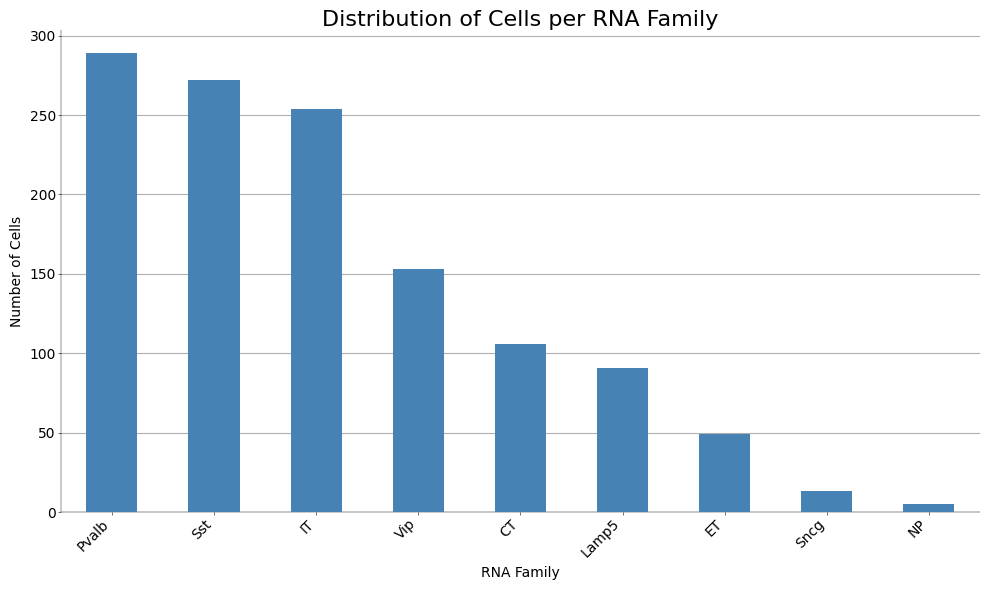

/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_29400/1741417890.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


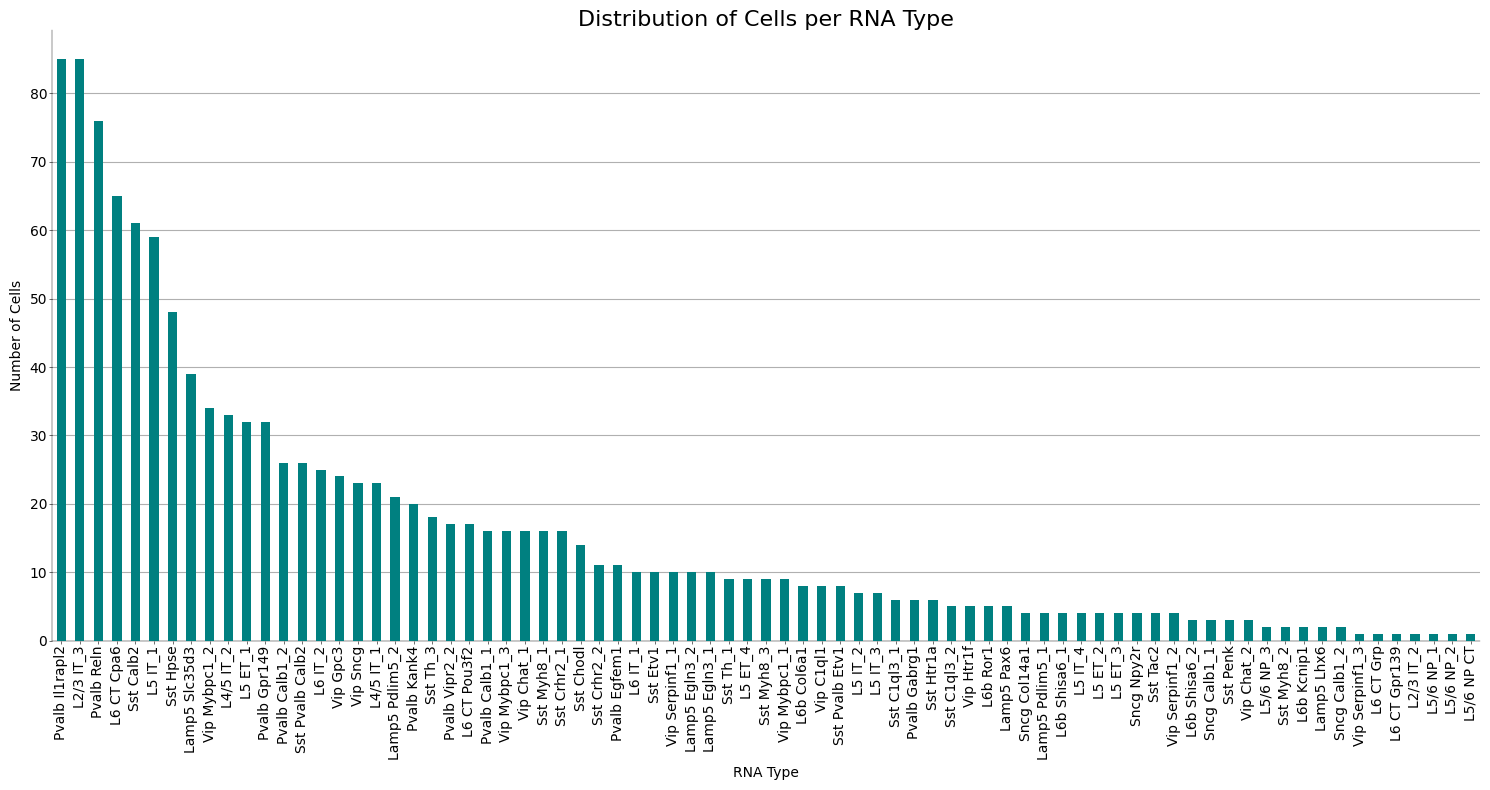

In [26]:
# Get the relevant metadata for the cells that passed initial QC
meta_qc = meta[exclude_low_quality].copy()

# --- Plotting RNA Family Distribution ---
fig, ax = plt.subplots(figsize=(10, 6))
family_counts = meta_qc["RNA family"].value_counts()
family_counts.plot(kind="bar", ax=ax, color="steelblue", zorder=10)
ax.set_title("Distribution of Cells per RNA Family", fontsize=16)
ax.set_xlabel("RNA Family")
ax.set_ylabel("Number of Cells")
ax.grid(axis="y")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# --- Plotting RNA Type Distribution ---
# This will be a busy plot due to 77 types, so we'll focus on the most abundant ones.
fig, ax = plt.subplots(figsize=(15, 8))
type_counts = meta_qc["RNA type"].value_counts()
type_counts.plot(kind="bar", ax=ax, color="teal", zorder=10)
ax.set_title("Distribution of Cells per RNA Type", fontsize=16)
ax.set_xlabel("RNA Type")
ax.set_ylabel("Number of Cells")
ax.grid(axis="y")
plt.tight_layout()
plt.show()

**Figure 5: Distribution of Cells per RNA Family.** This bar chart illustrates the number of cells belonging to each of the 9 major RNA families after filtering out low-quality samples.

*   **Imbalanced Representation:** The plot clearly shows a significant imbalance in the number of cells per family. The three most abundant families are `Pvalb`, `Sst` (both major classes of inhibitory interneurons), and `IT` (Intratelencephalic, a class of excitatory neurons), each comprising over 250 cells.
*   **Moderately Represented Families:** The `Vip`, `CT`, and `Lamp5` families are moderately represented, with counts ranging from approximately 90 to 150 cells.
*   **Rare Families:** The remaining families (`ET`, `Sncg`, `NP`) are very rare in this dataset, with fewer than 50 cells each.

**Figure 6: Distribution of Cells per RNA Type Reveals High Granularity and a Long-Tail Distribution.** This bar chart displays the number of cells for each of the 77 distinct RNA types, sorted in descending order.

*   **High Granularity and Extreme Imbalance:** The plot demonstrates a much finer level of classification compared to the RNA families. The distribution is highly skewed, exhibiting a classic "long-tail" pattern. The most abundant cell type, `Pvalb Il1rapl2`, has over 80 cells.
*   **Prevalence of Rare Types:** A vast majority of cell types are represented by a very small number of cells. More than half of the 77 types have fewer than 20 cells each, and many have fewer than 5.
*   **Analytical Implications:** This extreme imbalance poses a significant challenge for downstream analysis. Unsupervised clustering methods may struggle to identify these rare cell types, potentially merging them into larger, more prominent clusters. Similarly, performing statistical tests like differential gene expression for these rare populations would be difficult due to low statistical power. This highlights the difficulty of capturing the full spectrum of cellular diversity and underscores the value of the provided labels for validating the

/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_29400/952302924.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


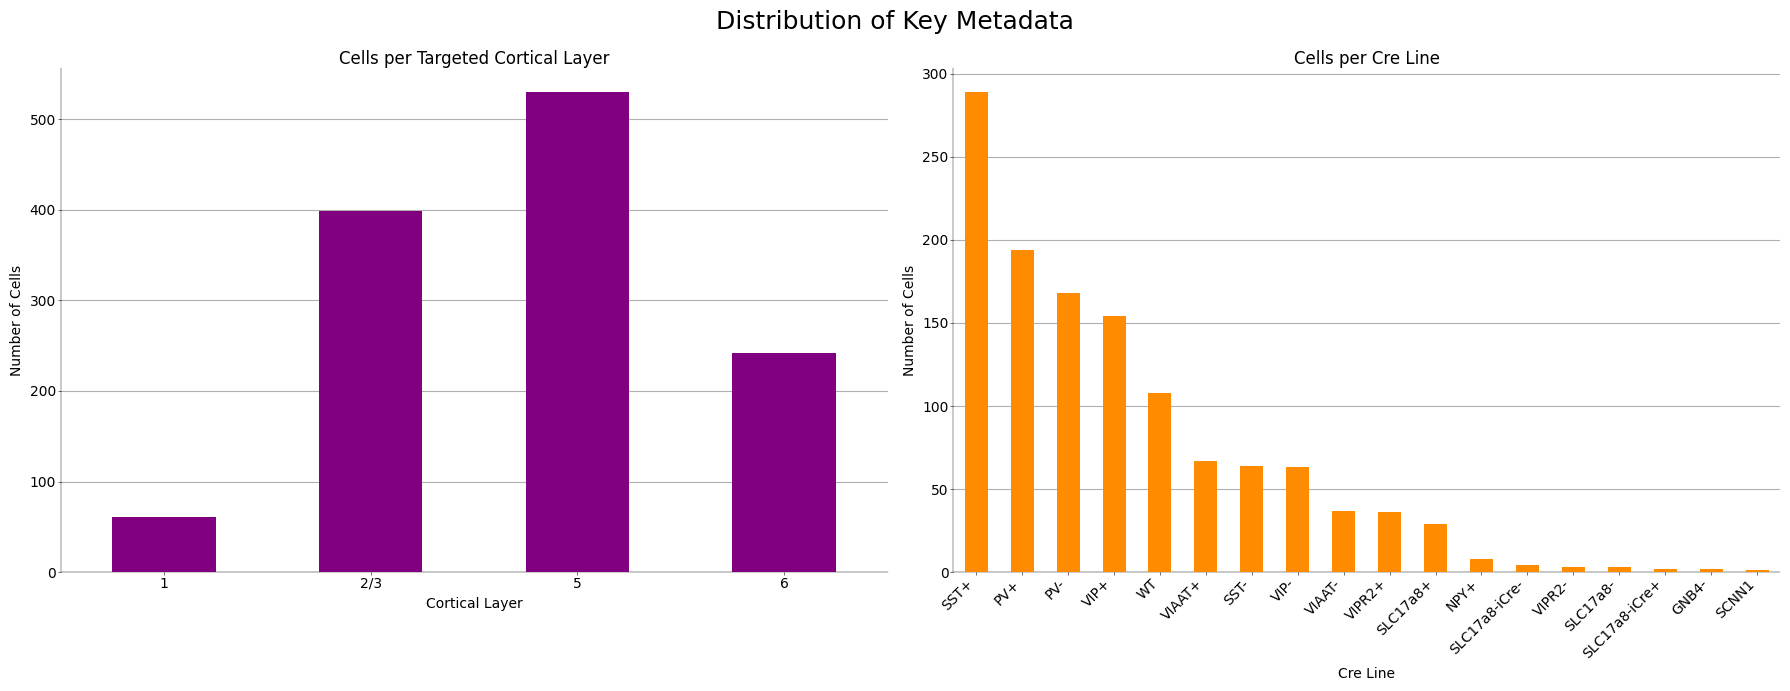

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("Distribution of Key Metadata", fontsize=18)

# Plot 1: Targeted Cortical Layer
layer_counts = meta_qc["Targeted layer"].value_counts().sort_index()
layer_counts.plot(kind="bar", ax=axes[0], color="purple", zorder=10)
axes[0].set_title("Cells per Targeted Cortical Layer")
axes[0].set_xlabel("Cortical Layer")
axes[0].set_ylabel("Number of Cells")
axes[0].grid(axis="y")
axes[0].tick_params(axis="x", rotation=0)

# Plot 2: Cre Line
cre_counts = meta_qc["Cre"].value_counts()
cre_counts.plot(kind="bar", ax=axes[1], color="darkorange", zorder=10)
axes[1].set_title("Cells per Cre Line")
axes[1].set_xlabel("Cre Line")
axes[1].set_ylabel("Number of Cells")
axes[1].grid(axis="y")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

**Figure 7: Distribution of Key Experimental Metadata.** This figure displays the cell counts for two important metadata variables: the targeted cortical layer (left) and the Cre driver line used for genetic targeting (right).

*   **Targeted Cortical Layer (Left):** The sampling of neurons was not uniform across the cortical depth. The majority of cells were collected from the middle and deep layers, specifically Layer 5 (~530 cells) and Layer 2/3 (~400 cells). Fewer cells were sampled from Layer 6 (~230 cells) and Layer 1 (~65 cells). This anatomical information is crucial, as many neuron types have specific laminar distributions, making it a valuable variable for validating cell type identities found through clustering.

*   **Cre Line (Right):** The experiment utilized a variety of Cre lines to target specific cell populations, but the sampling was highly imbalanced. The most frequently used lines targeted major classes of inhibitory interneurons, such as `SST+` (~290 cells), `PV+` (~190 cells), and `VIP+` (~155 cells). This aligns with the high number of cells observed in the `Sst`, `Pvalb`, and `Vip` RNA families.

*   **Analytical Implications:** These metadata variables introduce known biological structure into the dataset. The Cre line, in particular, can be a powerful tool for validating clustering results (e.g., cells from `SST+` mice should largely correspond to the `Sst` RNA family). However, it also acts as a potential batch effect or confounding variable, and care must be taken to ensure that analytical results reflect true biological differences rather than simply the experimental targeting

---
---
## Gene expression units explained: RPM, RPKM, FPKM, TPM, DESeq, TMM, SCnorm, GeTMM, and ComBat-Seq

---

### 1) Within-Sample Normalization

- **CPM**  
  - Basic gene expression unit that normalizes only for sequencing depth (depth-normalized counts). CPM is also known as RPM (Reads per million).  
  - CPM is calculated by dividing the mapped reads count by a per million scaling factor of total mapped reads.  
  - Since CPM does not consider gene length when normalizing, it is a suitable gene expression unit for sequencing protocols that generate reads regardless of gene length.

  $$CPM = \frac{\mathrm{Number\ of\ reads\ mapped\ to\ genes} \times10^6}{\mathrm{Total\ number\ of\ mapped\ reads}}$$
  
- **RPKM**
  - Normalized gene expression unit that measures the gene (transcript) abundance level in a sample.
  - RPKM is most useful for comparing gene expression values within a sample, and it is not recommended for performing differential gene expression analysis (sample-to-sample comparisons).
  - As RPKM considers the gene length for normalization, it is suitable for sequencing protocols where reads sequencing depends on gene length.
  - RPKM does not represent the accurate measure of relative RNA molar concentration (rmc) and can be biased towards identifying the differentially expressed genes as the total normalized counts for each sample will be different.

  $$RPKM = \frac{\mathrm{Number\ of\ reads\ mapped\ to\ genes}\times10^3 \times10^6}{\mathrm{Total\ number\ of\ mapped\ reads}\times\mathrm{gene\ length\ in\ bp\ to\ genes}}$$

- **TPM**  
  - TPM is proposed as an alternative to RPKM because of inaccuracy in RPKM measurement.
  - In contrast to RPKM, the TPM average is constant and is proportional to the relative RNA molar concentration (rmc).
  - TPM is suitable for sequencing protocols where reads sequencing depends on gene length.
$$TPM = \frac{RPKM}{\sum RPKM}\times10^6$$

---

### 2) Between-Sample Normalization

- **TMM**  
  - Normalize the total RNA output among the samples and does not consider gene length or library size for normalization.
  - TMM normalization method assumes that most of the genes are not differentially expressed.
  - TMM considers sample RNA population and effective in normalization of samples with diverse RNA repertoires.

- **DESeq2**  
  - DESeq2 calculates size factors for each sample to compare the counts obtained from different samples with different sequencing depth.
  - Similar to TMM, DESeq2 aslo assumes that most of the genes are not differentially expressed.
  - DESeq2 normalization uses the median of the ratios of observed counts to calculate size factors.
    - Size factor is calculated by first dividing the observed counts for each sample by its geometric mean.
    - The size factor is then calculated as the median of this ratio for each sample.
    - This size factor then used for normalizing raw count data for each sample.

- **SCnorm**  
  - Unbiased for scRNA-seq, which other normalization units have
    - abundance of zero expression counts
    - variable count-depth relationship (dependence of gene expression on sequencing depth)
    - other unwanted technical variations
  - Step
    - the estimates of expression counts (from RSEM, featureCounts or HTSeq)
    - Genes with low expression counts are filtered out
    - estimate the count-depth relationship using quantile regression
    - Cluster genes into groups with similar count-depth relationship
    - A scale factor is calculated from each group and used for estimation for normalized expression

- **ComBat-Seq**  
  - Adjust the count data by comparing the quantiles of the empirical distributions of data to the expected distribution without batch effects in the data.
  - Provides the output as integer counts in contrast to other normalization.
  - The resulting batch adjusted integer counts can be directly used with DESeq2.
--- 

### 3) Both Within/Between-Sample Normlization

- **GeTMM**
  - Based on the TMM normalization but allows the gene length correction.
  - Calculate RPK for each gene from raw read count data which is then corrected by TMM normalization factor and scaled to per million reads.

---
References  
1. https://www.reneshbedre.com/blog/expression_units.html

## 2.1 Normalize & transform the data

### Filtering based on QC

In [28]:
# mito gene mask
count_depth = exonCounts.sum(axis=1)
num_genes = (exonCounts > 0).sum(axis=1)

mito_mask = np.array([g.startswith(("mt-", "MT-")) for g in genes])
mito_counts = exonCounts[:, mito_mask].sum(axis=1)
mito_fraction = mito_counts / count_depth

# percentile-based threshold
low_pct, high_pct = 1, 99
low_count = np.percentile(count_depth, low_pct)
high_count = np.percentile(count_depth, high_pct)
low_genes = np.percentile(num_genes, low_pct)
high_genes = np.percentile(num_genes, high_pct)
mito_thresh = 0.10  # mito frac ≤10%

# cell filtering mask
keep_cells = (
    (count_depth >= low_count)
    & (count_depth <= high_count)
    & (num_genes >= low_genes)
    & (num_genes <= high_genes)
    & (mito_fraction <= mito_thresh)
)
print(f"Cells retained after QC: {keep_cells.sum()} / {len(keep_cells)}")

exonCounts_filt = exonCounts[keep_cells, :]

# gene filtering: min 20 cells expressing
min_cells = 20
keep_genes = (exonCounts_filt > 0).sum(axis=0) >= min_cells
print(f"Genes retained after filtering: {keep_genes.sum()} / {len(genes)}")

exonCounts_filt = exonCounts_filt[:, keep_genes]
genes_filt = genes[keep_genes]

# Final filtered data
print("Final count matrix shape:", exonCounts_filt.shape)

Cells retained after QC: 1169 / 1232
Genes retained after filtering: 23690 / 42466
Final count matrix shape: (1169, 23690)


### Comparing different noramlizations and transformations

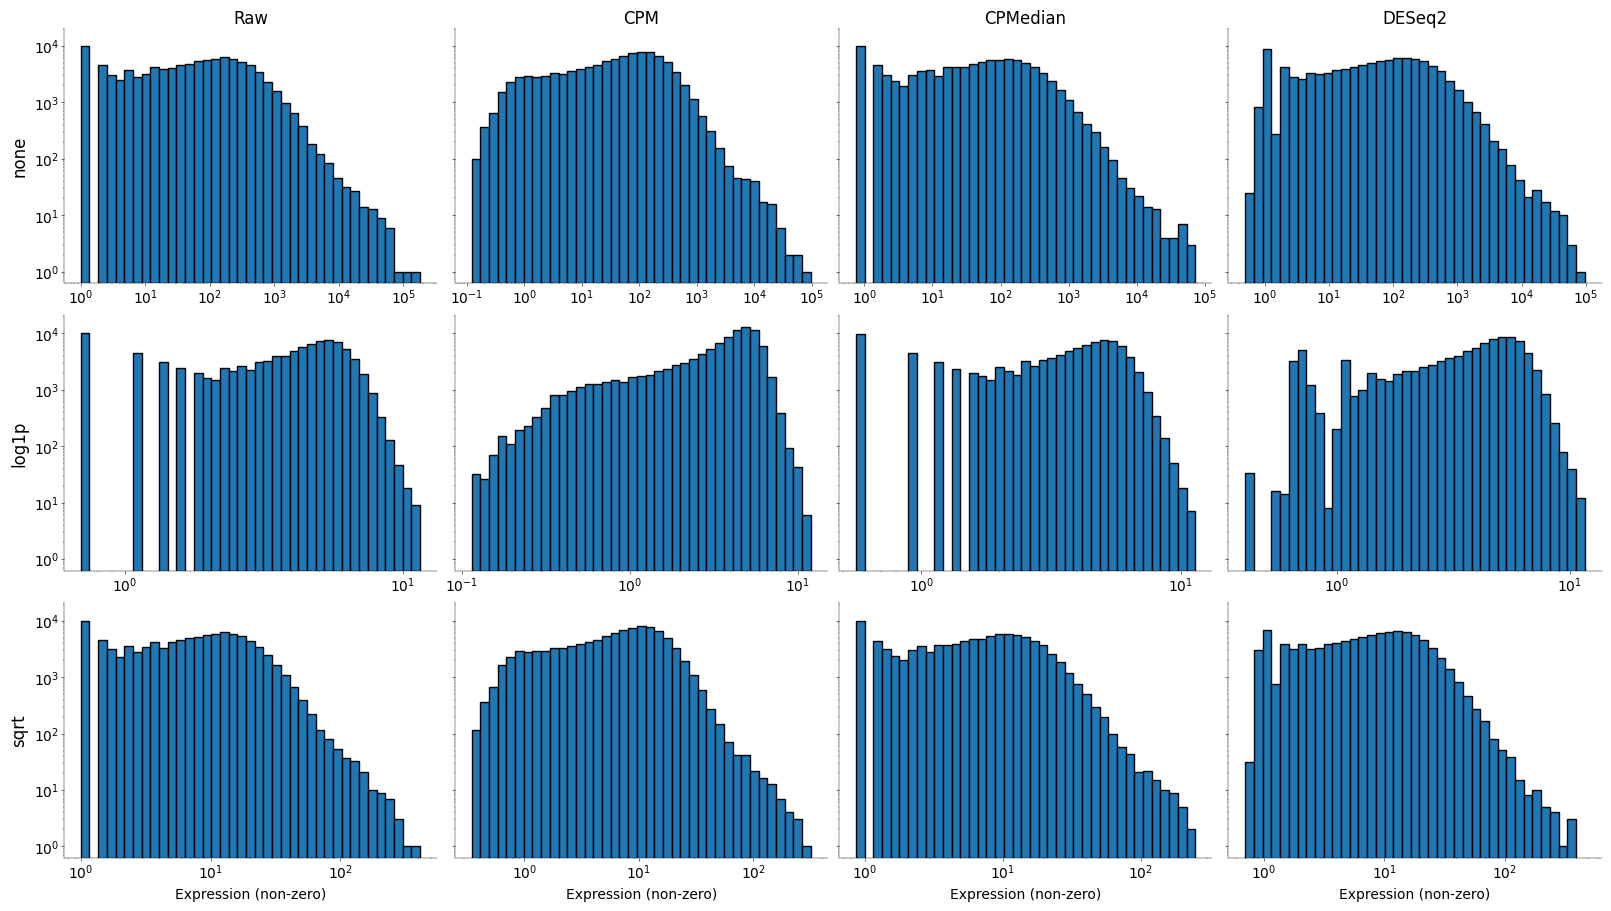

In [29]:
counts = exonCounts_filt.copy()

# Compute DESeq2 normalization
gm = np.exp(np.mean(np.log(counts + 1), axis=0))
valid = gm > 0
ratios = (counts[:, valid] + 1) / gm[valid][None, :]
size_factors = np.median(ratios, axis=1)
size_factors /= np.median(size_factors)
deseq_norm = counts / size_factors[:, None]

# Define normalization methods
libsize = counts.sum(axis=1)
median_lib = np.median(libsize)

norm_methods = {
    "Raw": counts,
    "CPM": counts / libsize[:, None] * 1e6,
    "CPMedian": counts / median_lib * 1e6,
    "DESeq2": deseq_norm,
}

# Define transformations
transforms = {
    "none": lambda x: x,
    "log1p": np.log1p,
    "sqrt": np.sqrt,
}

n_trans = len(transforms)
n_norm = len(norm_methods)
fig, axes = plt.subplots(
    n_trans, n_norm, figsize=(4 * n_norm, 3 * n_trans), sharey=True
)

for i, (trans_name, func) in enumerate(transforms.items()):
    for j, (norm_name, norm_mat) in enumerate(norm_methods.items()):
        mat = func(norm_mat)
        vals = mat.flatten()
        nonz = vals[vals > 0]
        if nonz.size > 100000:
            nonz = np.random.choice(nonz, 100000, replace=False)
        ax = axes[i, j]
        bins = np.logspace(np.log10(nonz.min()), np.log10(nonz.max()), 40)
        ax.hist(nonz, bins=bins, log=True, edgecolor="black")
        ax.set_xscale("log")
        if i == 0:
            ax.set_title(norm_name, fontsize=12)
        if j == 0:
            ax.set_ylabel(trans_name, fontsize=12)
        if i == n_trans - 1:
            ax.set_xlabel("Expression (non-zero)", fontsize=10)

plt.show()

**figure8: Non-zero expression distributions under different normalization and transformation schemes.**  

Columns compare raw counts (“Raw”), library-size scaling to counts-per-million (“CPM”) and counts-per-median-library (“CPMedian”), and DESeq2 median-of-ratios size-factor normalization (“DESeq2”). Rows show no further transform (“none”), a log1p transform, and a square-root transform.  
* **Raw/none:** The raw counts exhibit a heavy right skew: a small number of cells express each gene at very high levels, while most non-zeros remain clustered just above zero.
* **Raw/log1p & Raw/sqrt:** Both transforms reduce dynamic range, but log1p compresses extreme values more aggressively, producing a sharper peak at low expression and a gentler tail. Square-root sits between raw and log1p in terms of compression.
* **CPM/CPMedian vs. Raw:** Scaling by per-cell library size shifts and narrows the distribution slightly (CPMedian produces an almost identical profile to CPM), but the overall skew remains. DESeq2 further centers the bulk of non-zeros by using a robust size factor, flattening mid-range expression more evenly.
* **Effect of transforms after scaling:** Applying log1p to CPM or DESeq2 gives the most balanced profiles for downstream analysis—zeros remain at zero (not shown here), low values spread between 0–2, and the tail no longer dominates. Square-root still shows long tails but with less extreme variance than “none.”   

Taken together, log1p(CPM) (second column, second row) most effectively normalizes inter-cell depth differences while compressing large outliers, making it well suited for dimension-reduction and clustering.

## 2.2 select genes & apply PCA

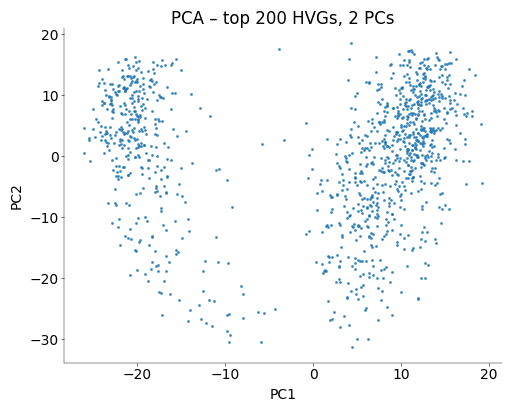

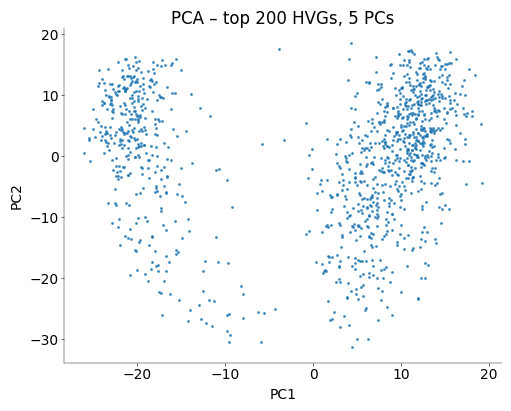

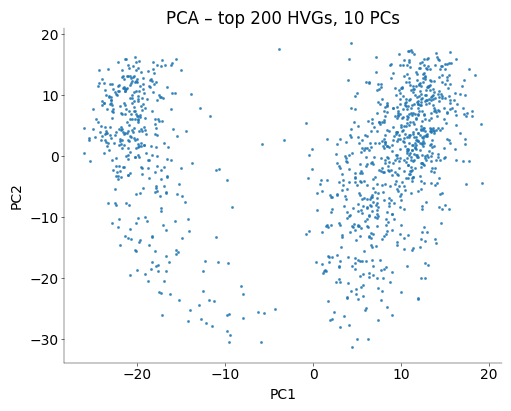

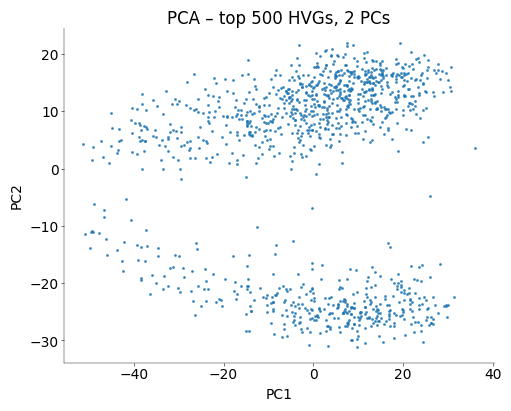

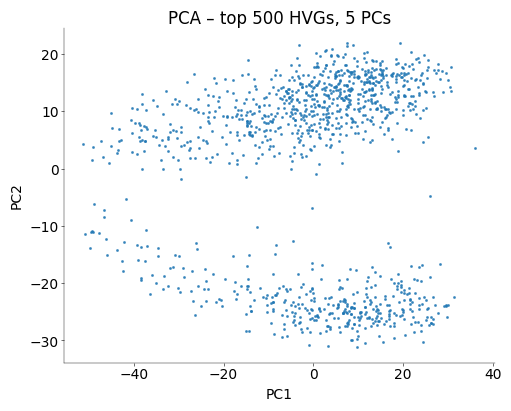

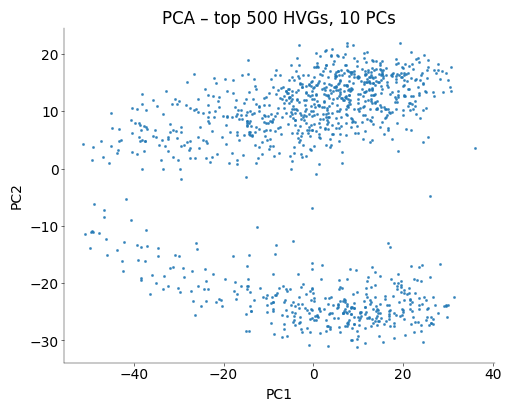

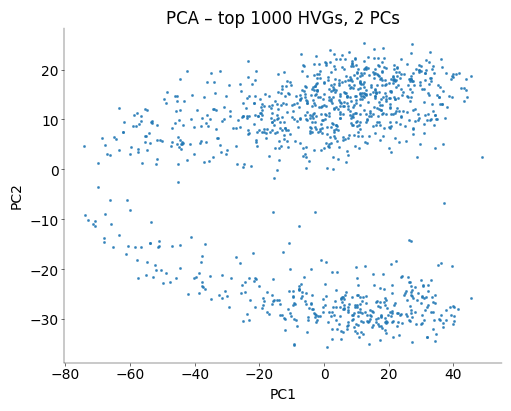

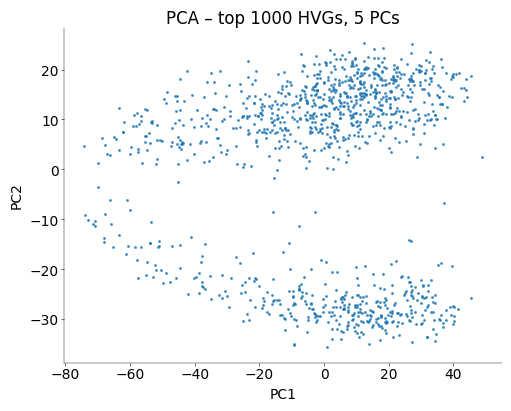

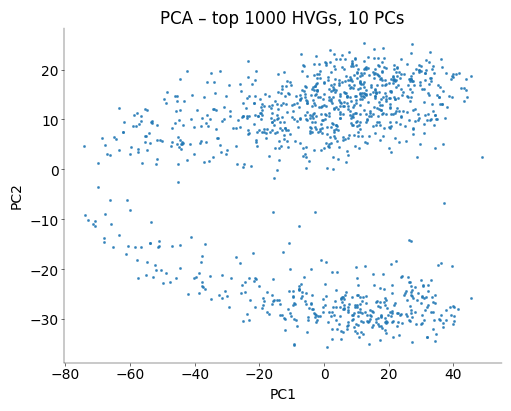

In [30]:
log_cpm = transforms["log1p"](
    norm_methods["CPM"]
)  # select best normalization and transformation
gene_vars = np.var(log_cpm, axis=0)

n_genes_list = [
    200,
    500,
    1000,
]  # Select different amount of highly variable genes
n_components_list = [2, 5, 10]  # Select different number of the PCA components

# Plot all 9 combinations
for n_genes in n_genes_list:
    top_idx = np.argsort(gene_vars)[-n_genes:]
    submat = log_cpm[:, top_idx]

    for n_comp in n_components_list:
        pca = PCA(n_components=n_comp)
        pcs = pca.fit_transform(submat)

        plt.figure(figsize=(5, 4))
        plt.scatter(pcs[:, 0], pcs[:, 1], s=5, alpha=0.7)
        plt.title(f"PCA – top {n_genes} HVGs, {n_comp} PCs")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()

**Figure 9: Impact of gene selection and PCA dimensionality on embedding stability.**  

* **Varying PCA components:** Keeping the same set of highly variable genes, increasing the number of principal components (e.g. from 2 to 10) has minimal effect on the two-dimensional projection. The major cell-to-cell relationships are already captured by the first two PCs, and additional components contribute only fine‐scale variation.
* **Varying gene set size:** Similarly, expanding the highly variable gene set (e.g. from 200 to 1 000 genes) does not materially alter the overall PCA embedding. The core biological structure—major clusters and separations—remains consistent, indicating that even a modest number of top-variable genes suffices to recover the principal axes of variation.

### Unsupervised clustering and dimension reduction

/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


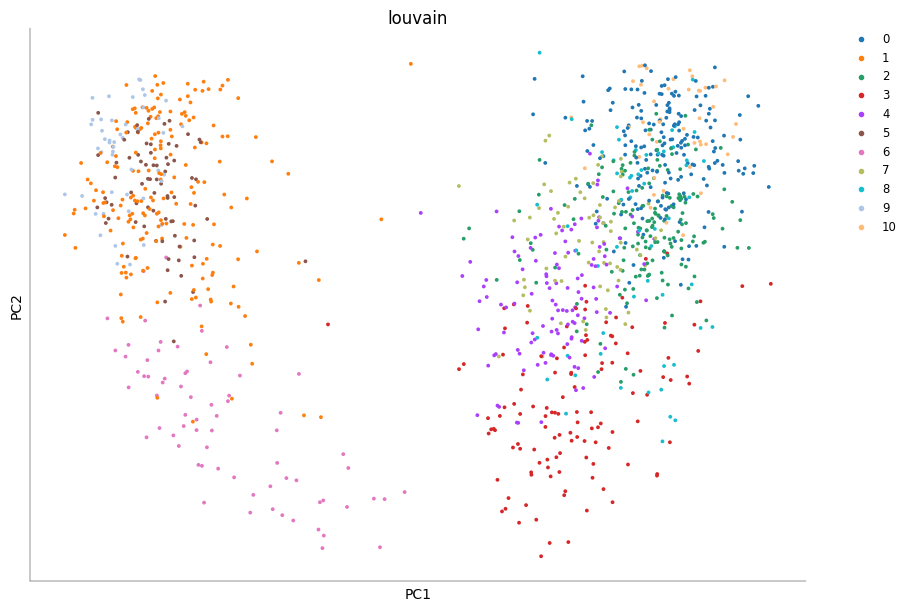

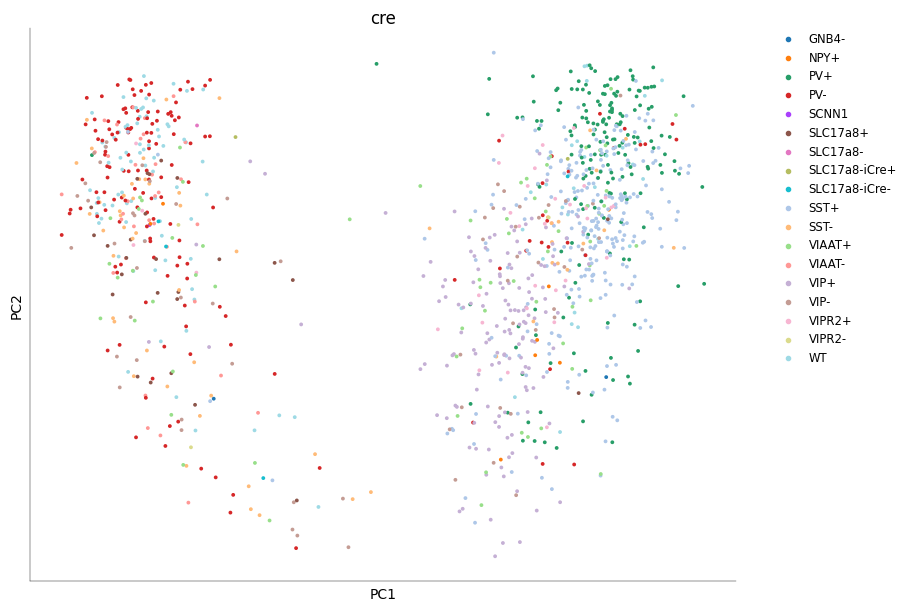

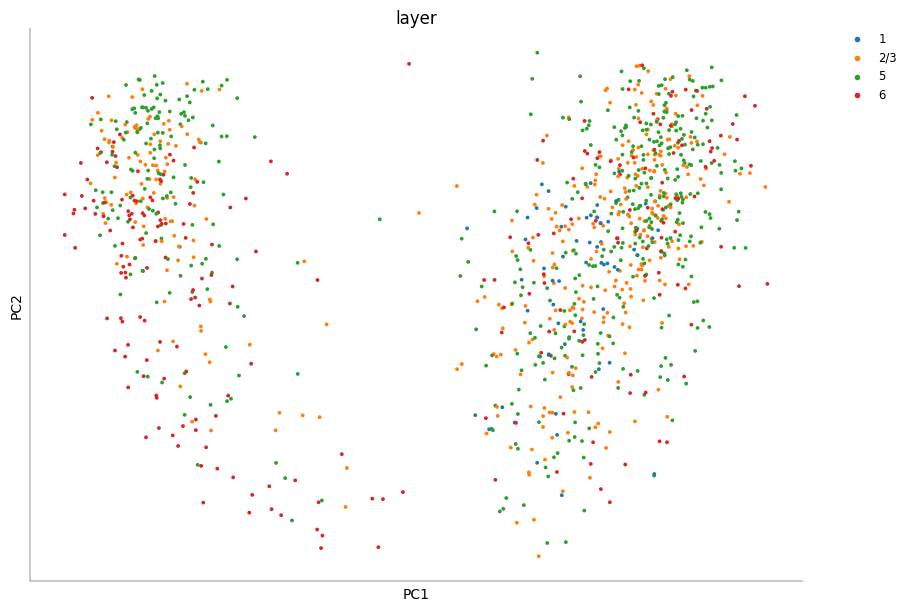

In [31]:
# top 200 HVGs
top200 = np.argsort(gene_vars)[-200:]
hvg_mat = log_cpm[:, top200]

cells_filt = cells[exclude_low_quality]
cre_filt = cre[exclude_low_quality]
layers_filt = layers[exclude_low_quality]

cells_filt = cells_filt[keep_cells]
cre_filt = cre_filt[keep_cells]
layers_filt = layers_filt[keep_cells]

adata = sc.AnnData(
    X=hvg_mat, obs=pd.DataFrame({"cre": cre_filt, "layer": layers_filt})
)


sc.pp.pca(adata, n_comps=20, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

# Louvain clustering
sc.tl.louvain(adata, key_added="louvain")

labels = ["louvain", "cre", "layer"]
for lb in labels:
    fig, ax = plt.subplots(figsize=(9, 6))
    sc.pl.pca(
        adata,
        color=lb,
        size=30,
        ax=ax,
        show=False,
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()
    ax.legend(
        handles,
        labels,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
        fontsize="small",
    )
    plt.show()

**Figure 10: Alignment of unsupervised Louvain clusters with PCA embedding, and annotation by Cre‐line and cortical layer.**

* **Cluster–PCA correspondence:** The Louvain cluster assignments exactly overlie onto the PC1–PC2 embedding. This tight alignment tells us that the graph‐based community structure recovered by Louvain clustering is essentially the same as the dominant axes of variation captured by the first two principal components.
* **Cre‐line labeling:** Coloring each point by its Cre genotype shows that cells from all Cre lines are distributed across both lobes. However, some of Cre cells are recognizably biased to one side. For example, Cre- PV-, SLC17a8+, and WT cells slightly more frequent in the left lobe and Cre- PV+, SST+, VIP+ cells in the right.
* **Layer labeling:** When we color by cortical layer (1, 2/3, 5, 6), execpt layer 1 (***blue***), all layers are well distributed across the PCs. In contrast ot other layers, layer 1 is captured in the right lobe where PC1 distinguish it with high value.

---
---

## The art of seeing the elephant in the room
---

### 1) Advantage of 2D embedings of single cell data

Although two-dimensional embeddings inevitably distort high-dimensional distances—and thus should be interpreted with caution rather than trusted blindly—they can nonetheless be very useful. As George Box said, “All models are wrong, but some are useful,” and this applies equally to 2D projections of single-cell data. Because of the curse of dimensionality, preserving every pairwise distance in two dimensions may even be undesirable: methods like multidimensional scaling (MDS), which aim to maintain global distances, often fail to reveal clear cluster structure in practice. By contrast, t-SNE and UMAP are not designed to conserve all distances, yet they reliably capture local neighborhoods and separate biologically meaningful cell groups. Rather than focusing on absolute distances, biologists are most interested in identifying cell clusters, and quantitative metrics of neighborhood and class preservation show that t-SNE and UMAP excel at this task. In other words, while 2D embeddings do not perfectly reflect every high-dimensional relationship, they can still uncover the structure that matters most in single-cell analysis.

---
### 2) Embeding quality metrics

* **distance preservation**

## 3.1 PCA, t-SNE and UMAP comparision

### t-SNE and UMAP

/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


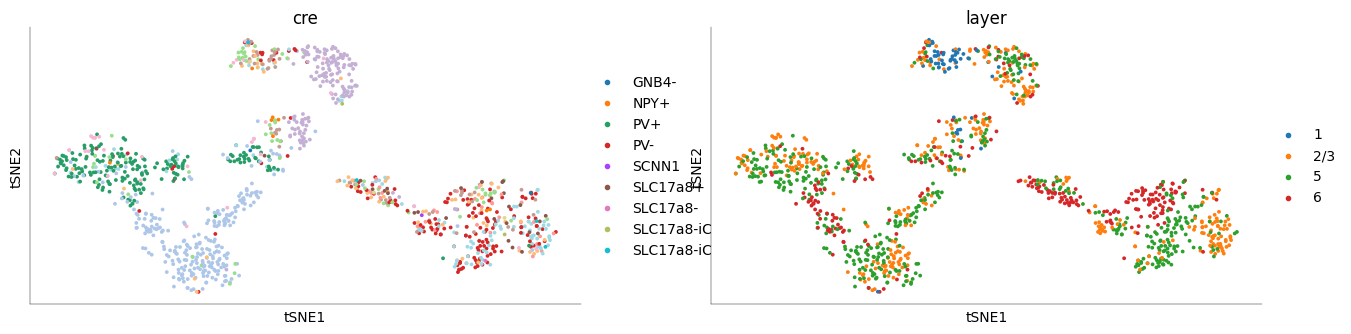

/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


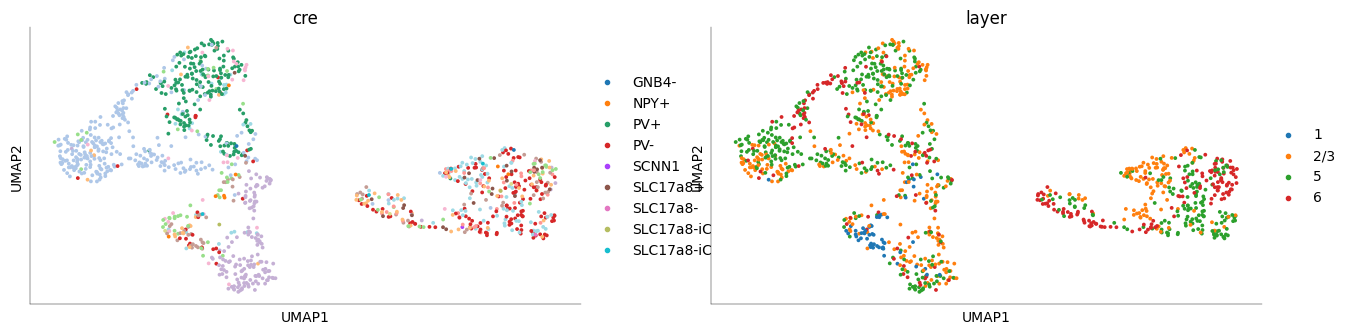

In [32]:
# t-SNE
sc.tl.tsne(
    adata,
    use_rep="X_pca", 
    perplexity=30,
    n_pcs=20,
)
sc.pl.tsne(adata, color=["cre", "layer"], size=30)

# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=["cre", "layer"], size=30)

### Quality metrics

In [34]:
pca2d = adata.obsm["X_pca"][:, :2]  # first two PCs
tsne2d = adata.obsm["X_tsne"]
umap2d = adata.obsm["X_umap"]

# ground truth labels
labels_type = rna_type[keep_cells]
labels_family = rna_family[keep_cells]

# ground‐truth kNN from high-dim
hd = adata.obsm["X_pca"]
k = 15
nn_hd = NearestNeighbors(n_neighbors=k + 1).fit(hd)
_, idx_hd = nn_hd.kneighbors(hd)
neighbors_hd = idx_hd[:, 1:]


# kNN preservation (recall)
def knn_recall(lowd):
    nn_ld = NearestNeighbors(n_neighbors=k + 1).fit(lowd)
    _, idx_ld = nn_ld.kneighbors(lowd)
    nbrs_ld = idx_ld[:, 1:]
    return np.mean(
        [
            len(np.intersect1d(neighbors_hd[i], nbrs_ld[i])) / k
            for i in range(lowd.shape[0])
        ]
    )


records = []
for truth_name, labels in [
    ("RNA Type", labels_type),
    ("RNA Family", labels_family),
]:
    # ensure integer label codes
    y = pd.Categorical(labels).codes
    n_cls = len(np.unique(y))
    for emb_name, mat in [("PCA", pca2d), ("tSNE", tsne2d), ("UMAP", umap2d)]:
        rec = knn_recall(mat)
        sil = silhouette_score(mat, y)
        km = KMeans(n_clusters=n_cls, random_state=0).fit(mat)
        ami = adjusted_mutual_info_score(y, km.labels_)
        records.append((truth_name, emb_name, rec, sil, ami))

df_metrics = pd.DataFrame(
    records, columns=["Truth", "Embedding", "kNN Recall", "Silhouette", "AMI"]
)
display(df_metrics)

,Truth,Embedding,kNN Recall,Silhouette,AMI
0,RNA Type,PCA,0.141146,-0.505522,0.186118
1,RNA Type,tSNE,0.551069,-0.362164,0.401365
2,RNA Type,UMAP,0.491075,-0.323348,0.396799
3,RNA Family,PCA,0.141146,-0.049828,0.425210
4,RNA Family,tSNE,0.551069,0.248714,0.646038
5,RNA Family,UMAP,0.491075,0.232179,0.686352


## 3.2 Additional Embedding method

/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, usin

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/scanpy/tools/_tsne.py:115: UserWarning: You’re trying to run this on 200 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)
/Users/admin/miniforge3/envs/nds_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


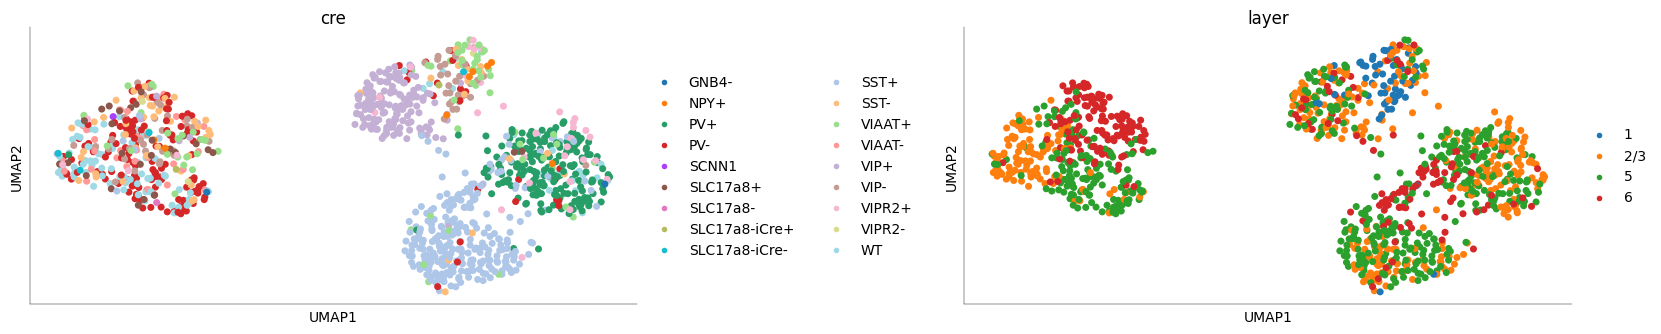

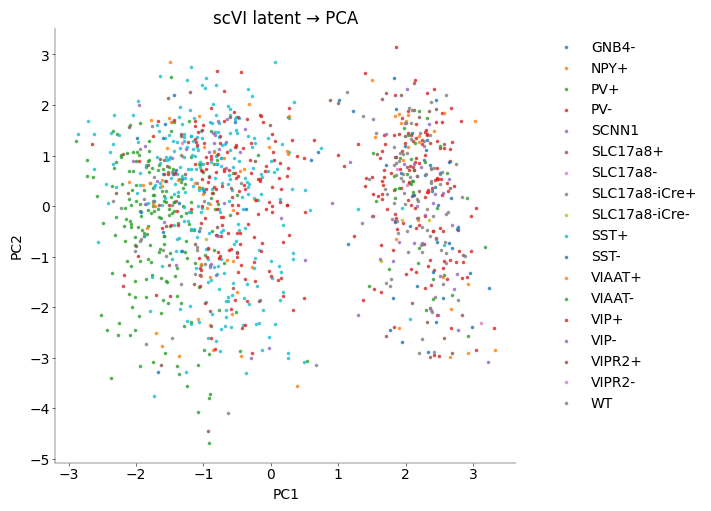

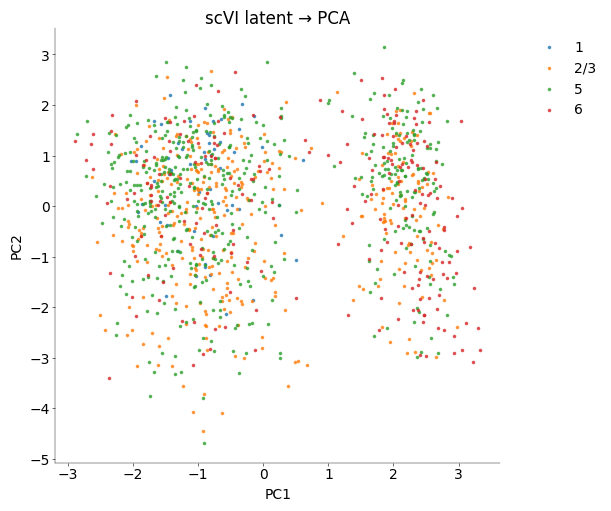

In [35]:
# Latent embedding by VAE
import scvi
import warnings

adata_latent = sc.AnnData(
    X=hvg_mat, obs=dict(cell=cells_filt, cre=cre_filt, layer=layers_filt)
)

adata_latent.obs["library_size"] = adata.X.sum(axis=1).astype(float)
scvi.model.SCVI.setup_anndata(
    adata_latent,
    batch_key=None,
    labels_key=None,
    continuous_covariate_keys=["library_size"],
)

# Instantiate & train the model
model = scvi.model.SCVI(adata_latent, n_latent=20)
warnings.filterwarnings(
    "ignore",
    message="The value argument must be within the support of the distribution",
)
model.train(max_epochs=100)

# latent embedding for downstream (neighbors, UMAP, clustering)
adata_latent.obsm["X_scVI"] = model.get_latent_representation()

# normalized, denoised expression matrix
norm_exp = model.get_normalized_expression()

# t-SNE
sc.tl.tsne(adata_latent)

# Visualize UMAP
sc.pp.neighbors(adata_latent, use_rep="X_scVI")
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=["cre", "layer"], wspace=0.4)

Z = adata_latent.obsm["X_scVI"]

# visualize PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(Z)

# scatter
plt.figure(figsize=(7, 5))
for grp in np.unique(adata_latent.obs["cre"]):
    mask = adata_latent.obs["cre"] == grp
    plt.scatter(pcs[mask, 0], pcs[mask, 1], label=grp, s=10, alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("scVI latent → PCA")
plt.show()

plt.figure(figsize=(6, 5))
for grp in np.unique(adata_latent.obs["layer"]):
    mask = adata_latent.obs["layer"] == grp
    plt.scatter(pcs[mask, 0], pcs[mask, 1], label=grp, s=10, alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("scVI latent → PCA")
plt.show()

In [36]:
scvi2d = adata_latent.obsm["X_scVI"][:, :2]
tsne2d_latent = adata_latent.obsm["X_tsne"]
umap2d_latent = adata_latent.obsm["X_umap"]

# 2) Build high-dim kNN once (uses the full latent)
hd = adata_latent.obsm["X_scVI"]
k = 15
nn_hd = NearestNeighbors(n_neighbors=k + 1).fit(hd)
_, idx_hd = nn_hd.kneighbors(hd)
neighbors_hd = idx_hd[:, 1:]


def knn_recall(lowd):
    nn_ld = NearestNeighbors(n_neighbors=k + 1).fit(lowd)
    _, idx_ld = nn_ld.kneighbors(lowd)
    nbrs_ld = idx_ld[:, 1:]
    return np.mean(
        [
            len(np.intersect1d(neighbors_hd[i], nbrs_ld[i])) / k
            for i in range(lowd.shape[0])
        ]
    )


records = []
for truth_name, labels in [
    ("RNA Type", labels_type),
    ("RNA Family", labels_family),
]:
    # ensure integer label codes
    y = pd.Categorical(labels).codes
    n_cls = len(np.unique(y))
    for emb_name, mat in [
        ("scVI", scvi2d),
        ("tSNE", tsne2d_latent),
        ("UMAP", umap2d_latent),
    ]:
        rec = knn_recall(mat)
        sil = silhouette_score(mat, y)
        km = KMeans(n_clusters=n_cls, random_state=0).fit(mat)
        ami = adjusted_mutual_info_score(y, km.labels_)
        records.append((truth_name, emb_name, rec, sil, ami))

df_metrics_latent = pd.DataFrame(
    records, columns=["Truth", "Embedding", "kNN Recall", "Silhouette", "AMI"]
)
display(df_metrics_latent)

,Truth,Embedding,kNN Recall,Silhouette,AMI
0,RNA Type,scVI,0.061078,-0.517123,0.099570
1,RNA Type,tSNE,0.282521,-0.336539,0.419622
2,RNA Type,UMAP,0.333618,-0.270835,0.386197
3,RNA Family,scVI,0.061078,-0.097203,0.207313
4,RNA Family,tSNE,0.282521,0.249112,0.630950
5,RNA Family,UMAP,0.333618,0.325730,0.725532


### 3.3 Enhancing visualization using electrophysiology and meta data

In [ ]:
# Use "adata" not "adata_latent". Latent embedding method is similar or underscore than default one.
# you can recall the result of pca,tsne,umap by
pca2d = adata.obsm["X_pca"][:, :2]  # first two PCs
tsne2d = adata.obsm["X_tsne"]
umap2d = adata.obsm["X_umap"]
# after quality control cell and genes are selected
# you can filter those genes directly to the data by using like this
# for example 
depth_filt = depth[exclude_low_quality] #if the shape is (1329,) -> (1232,)
depth_filt_by_QC = depth_filt[keep_cells] # (1232,) -> (1169,)
# For the electrophysiology data shape maybe same... (1329,) -> (1232,) -> (1169,) if not working, check the code at 2.1 - "Filtering based on QC"